In [1]:
%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd

from pyspark.sql import functions as F
from pyspark.sql import types as T

import seaborn as sns

In [2]:
sns.set_style('ticks')
sns.set_context('paper')

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['savefig.dpi'] = 600
matplotlib.rcParams['lines.markersize'] = 3
matplotlib.rcParams['lines.linewidth'] = 1

pd.options.display.width = 200


## Normalize citations by journal citations

$C_{p}$ = Number of citations of a paper

$\epsilon = 0.01$ = Correction factor

$\delta_{J_y} = \sum_{p \in J_y}{\frac{log_{10}(C_{p} + \epsilon)}{n(J_y)}}$

$C_{J_y} = 10^{\delta_{J_y}} - \epsilon$ = Average citations of a journal in an year

$C'_{p} = \frac{C_{p} + \epsilon}{C_{J_y} + \epsilon}$ = Journal year normalized citations of a paper

In [4]:
def read_cites(x):
    x = x.split("\t")
    pmid = int(x[0])
    year = int(x[1])
    journal = x[2]
    ncites = int(x[3])
    return ((journal, year), [(pmid, ncites)])

In [30]:
cites_data = sc.textFile("data/pmid_journal_ncitedby.nohead.txt").map(read_cites)
cites_data.take(10)

[((u'Nat Nanotechnol', 2013), [(23455984, 4)]),
 ((u'J Am Vet Med Assoc', 2003), [(12710772, 1)]),
 ((u'Fitoterapia', 2000), [(11449481, 11)]),
 ((u'Q J Med', 1983), [(6683854, 23)]),
 ((u'Biophys J', 2003), [(12719236, 192)]),
 ((u'PLoS One', 2012), [(23209684, 8)]),
 ((u'J Fish Dis', 2010), [(19735345, 3)]),
 ((u'Drug Test Anal', 2012), [(22389110, 1)]),
 ((u'Brain Res Bull', 2009), [(19038315, 10)]),
 ((u'Clin Rehabil', 2003), [(12785247, 3)])]

In [31]:
LOG_CORRECTION = 0.01
def journal_standardize_cites(x, plot=False):
    journal, year = x[0]
    pmids, cites = zip(*x[1])
    cites = np.array(cites, dtype="float")
    mean_cites = np.mean(np.log10(cites + LOG_CORRECTION))
    mean_cites = (10**mean_cites) - LOG_CORRECTION
    normed_cites = (cites + LOG_CORRECTION) / (mean_cites + LOG_CORRECTION)
    if plot:
        print cites.shape, cites.min(), cites.max(), mean_cites
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(1,2, sharey=True)
        ax[0].hist(cites, bins=10, log=True)
        ax[0].axvline(x=mean_cites, linestyle="--")
        ax[1].hist(normed_cites, bins=10, log=True)
        ax[0].set_xlabel("Original")
        ax[1].set_xlabel("Normed")
    return ((k[0], mean_cites, k[1], k[2]) for k in zip(pmids, cites, normed_cites))
        
        

In [32]:
t = cites_data.reduceByKey(lambda x,y: x+y).take(5)

In [9]:
t[0]

((u'Mol Biol Cell', 1998),
 [(9843570, 28),
  (9693371, 30),
  (9763450, 64),
  (9802900, 40),
  (9614171, 141),
  (9529377, 62),
  (9487132, 63),
  (9843585, 71),
  (9658161, 93),
  (9725920, 29),
  (9693363, 17),
  (9529385, 204),
  (9843568, 23),
  (9658176, 412),
  (9571246, 230),
  (9487127, 11),
  (9725898, 21),
  (9571239, 68),
  (9658159, 27),
  (9763444, 38),
  (9450953, 77),
  (9843580, 53),
  (9571251, 129),
  (9693382, 141),
  (9725917, 154),
  (9614176, 28),
  (9436990, 28),
  (9763448, 32),
  (9614193, 84),
  (9436996, 94),
  (9614187, 76),
  (9450968, 143),
  (9658175, 70),
  (9802905, 302),
  (9843571, 162),
  (9529372, 39),
  (9802894, 33),
  (9693366, 100),
  (9658174, 43),
  (9658168, 86),
  (9614188, 54),
  (9450954, 67),
  (9658155, 18),
  (9802901, 68),
  (9571240, 74),
  (9763441, 15),
  (9436995, 27),
  (9725914, 242),
  (9529391, 74),
  (9487126, 111),
  (9450970, 24),
  (9614179, 18),
  (9614196, 191),
  (9450951, 23),
  (9529373, 62),
  (9763447, 91),
  (9725

(369,) 0.0 232.0 10.6614480121


<generator object <genexpr> at 0x7ff1ff32a820>

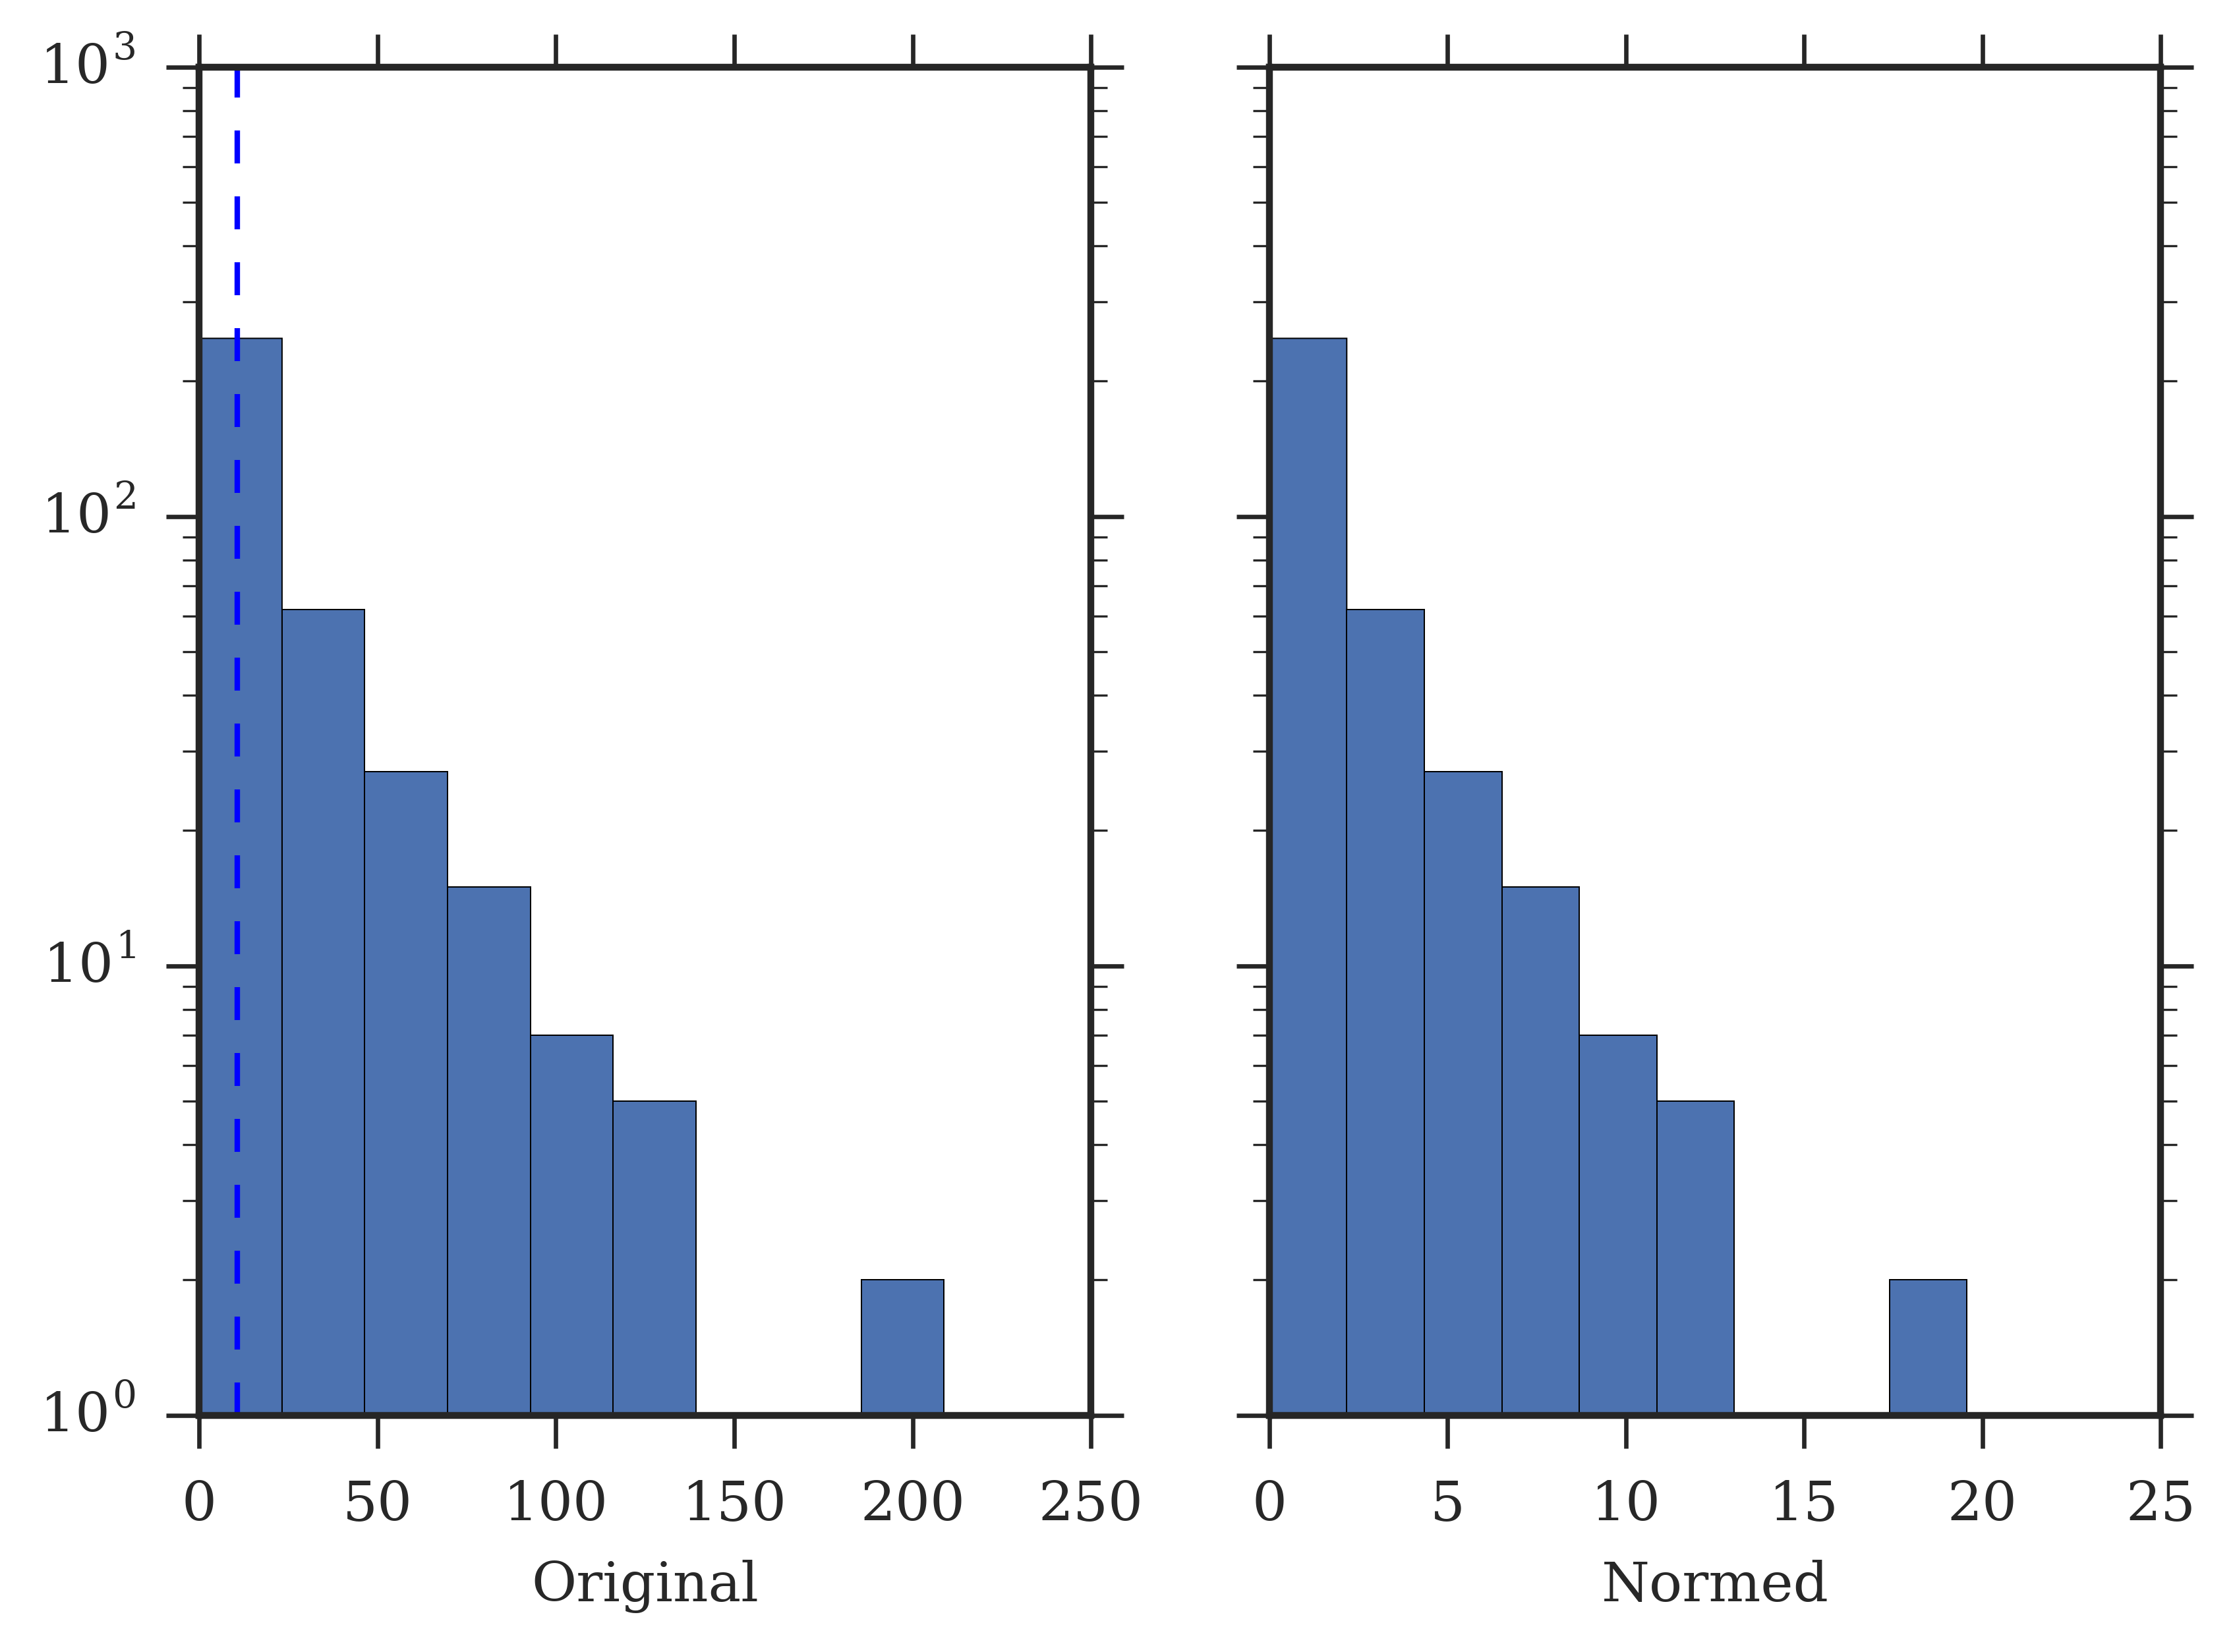

In [33]:
journal_standardize_cites(t[4], plot=True)

In [34]:
cites_data.reduceByKey(lambda x,y: x+y).flatMap(journal_standardize_cites).map(
    lambda x: "\t".join("%s" for k in xrange(len(x))) % x).saveAsTextFile("out/citation_normed_score")

In [35]:
! head out/citation_normed_score/part-00000

9843570	53.2868042263	28.0	0.525547458363
9693371	53.2868042263	30.0	0.563073160495
9763450	53.2868042263	64.0	1.20101009674
9802900	53.2868042263	40.0	0.750701671157
9614171	53.2868042263	141.0	2.64574962884
9529377	53.2868042263	62.0	1.16348439461
9487132	53.2868042263	63.0	1.18224724568
9843585	53.2868042263	71.0	1.33235005421
9658161	53.2868042263	93.0	1.74513277766
9725920	53.2868042263	29.0	0.544310309429


In [3]:
def read_cites_data(x):
    x = x.split("\t")
    pmid = int(x[0])
    mean_cites = float(x[1])
    ncites = float(x[2])
    normed_cites = float(x[3])
    return (pmid, mean_cites, ncites, normed_cites)

In [4]:
cites_data = sc.textFile("out/citation_normed_score").map(read_cites_data)
cites_data.take(3)

[(20302682, 8.0, 8.0, 1.0),
 (25914722, 0.0, 0.0, 1.0),
 (10959503, 4.71490765273, 2.0, 0.425405139683)]

In [24]:
hist_data = cites_data.map(lambda x: x[2]).histogram(10)

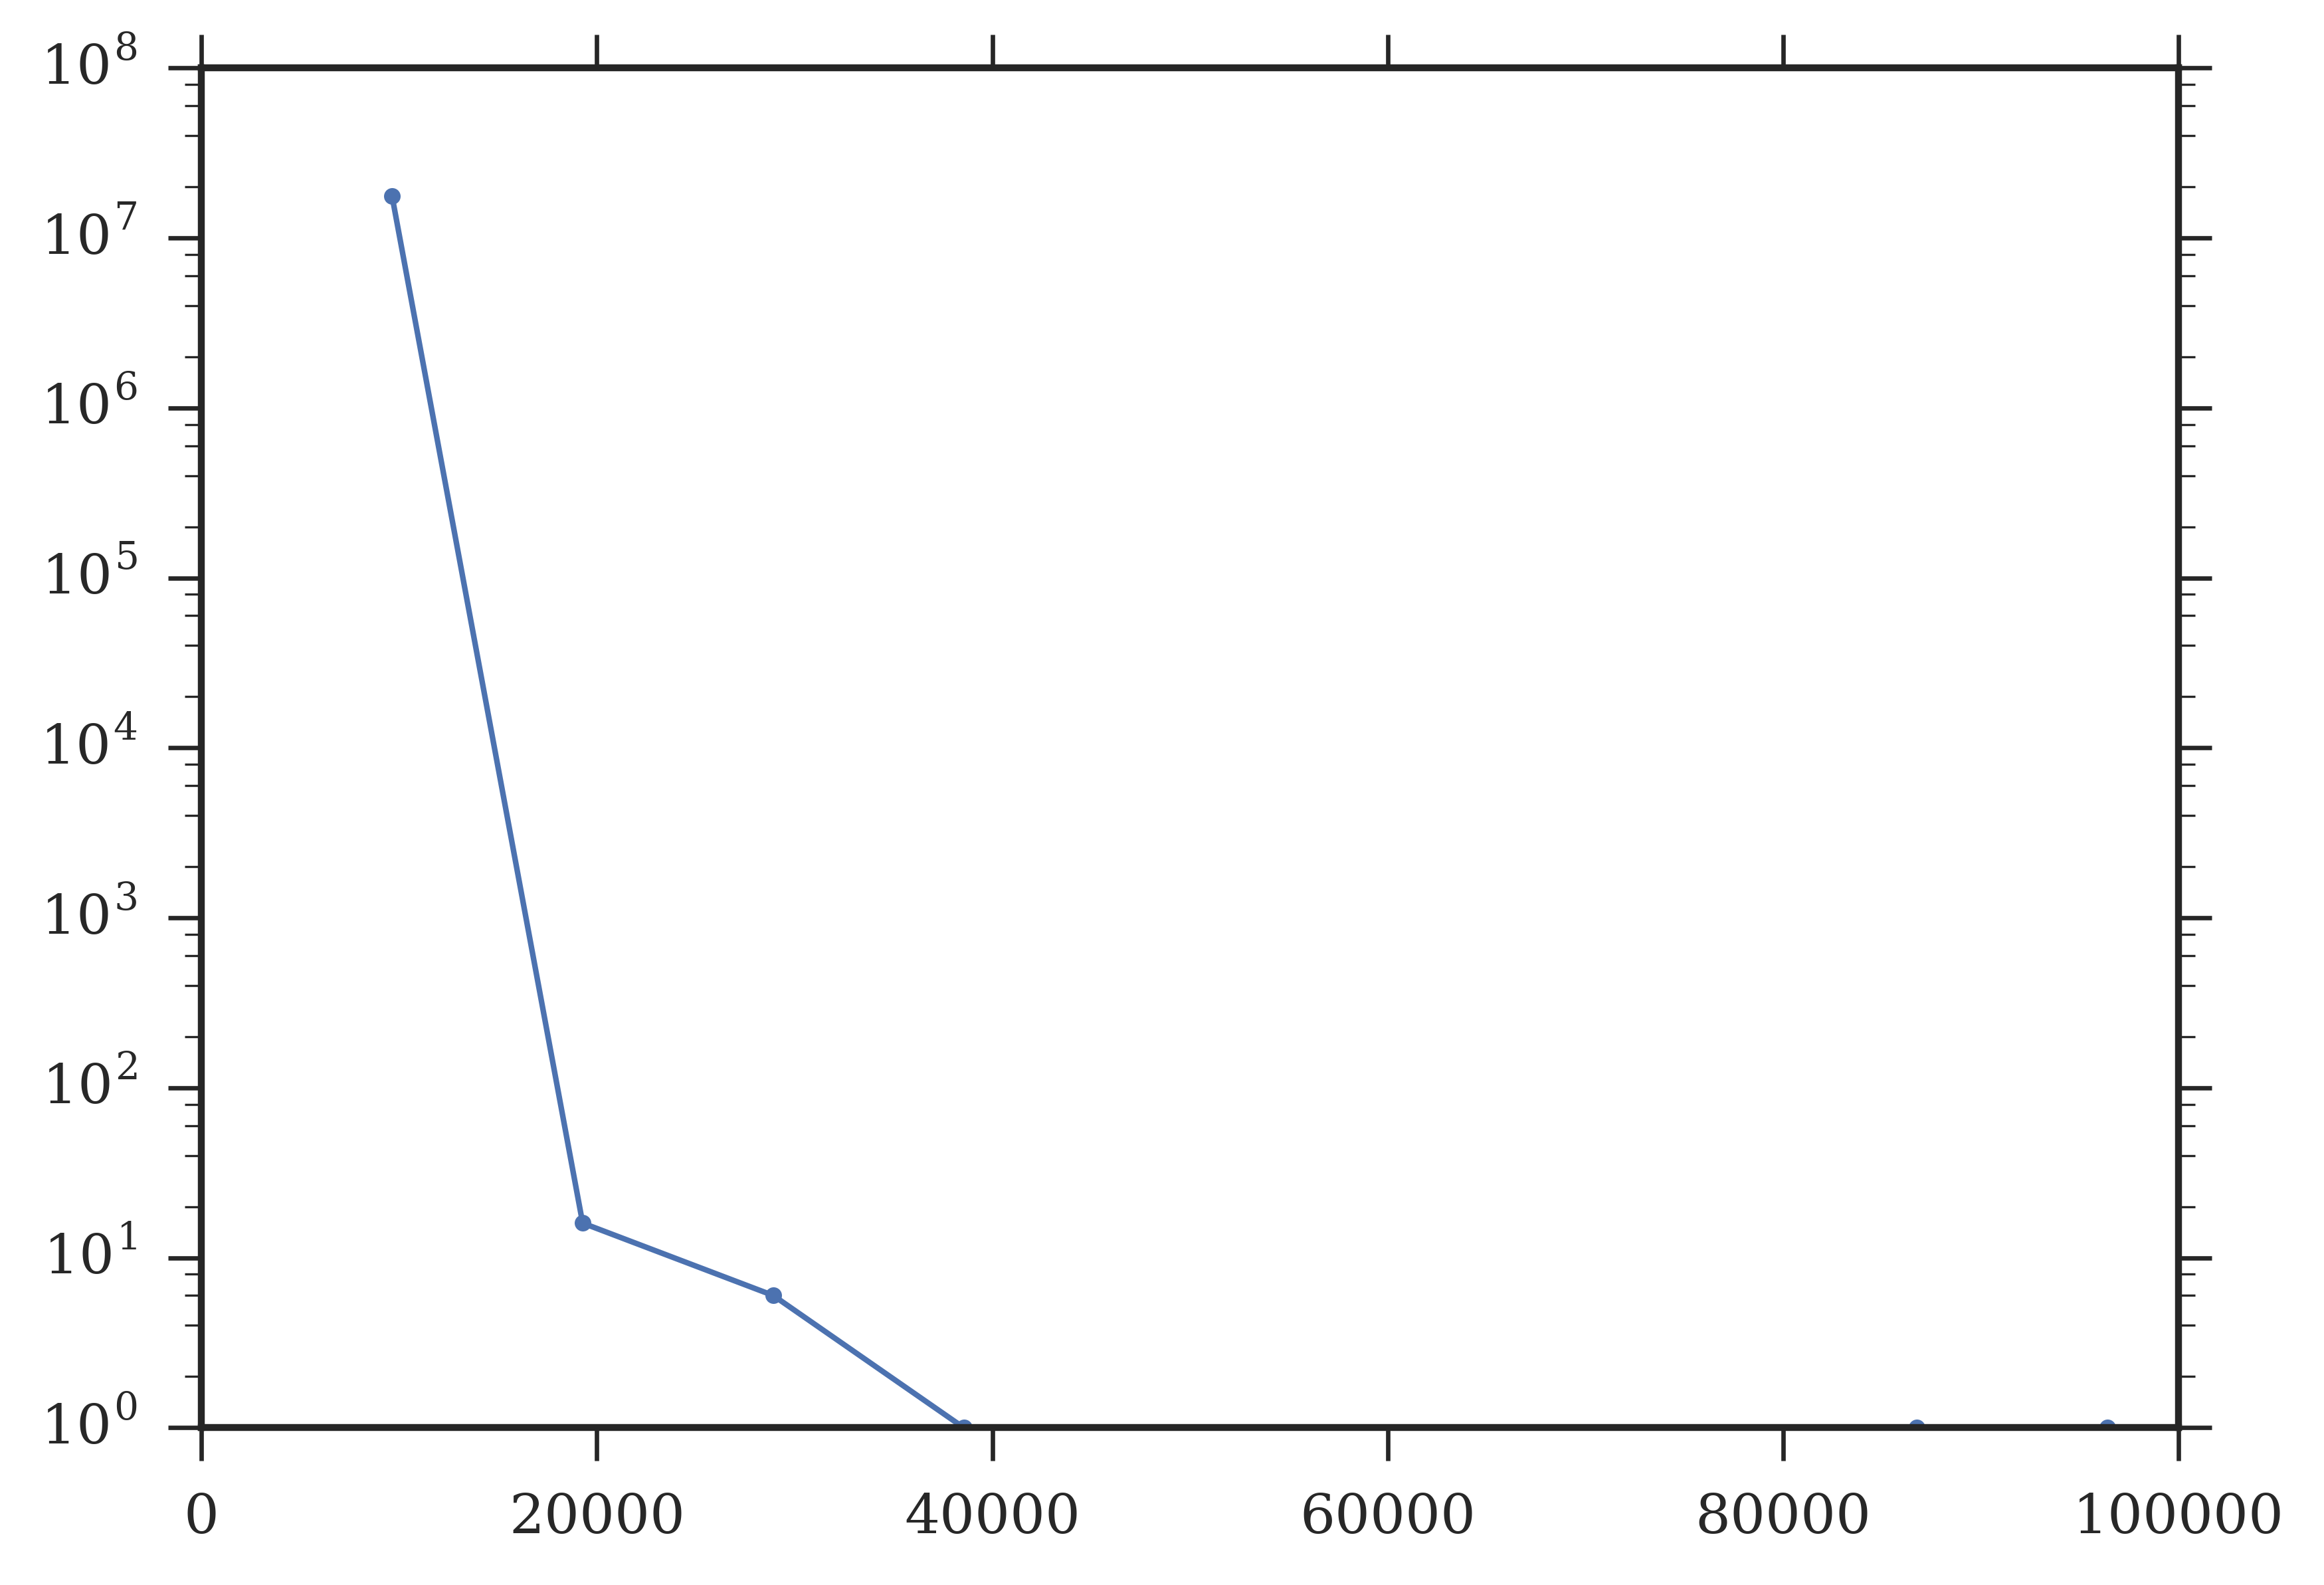

In [25]:
plt.close("all")
plt.clf()
plt.plot(hist_data[0][1:], hist_data[1], marker="o")
plt.yscale("log")

In [41]:
hist_data

([-3.60555127546,
  36.703984505186,
  77.013520285832,
  117.323056066478,
  157.63259184712402,
  197.94212762777002,
  238.25166340841602,
  278.561199189062,
  318.870734969708,
  359.180270750354,
  399.489806531],
 [17640517, 545, 43, 8, 4, 1, 1, 0, 0, 1])

In [5]:
def clean_null(x):
    return float(x) if x != "\N" else np.nan

def read_novelty(x):
    x = x.split("\t")
    pmid = int(x[0])
    year = int(x[1])
    TFirstP = clean_null(x[3])
    VolFirstP = clean_null(x[4])
    Pair_TFirstP = clean_null(x[10])
    Pair_VolFirstP = clean_null(x[11])
    num_mesh = int(x[12])
    num_ex_mesh = int(x[13])
    return (pmid, [pmid, year, TFirstP, VolFirstP, Pair_TFirstP, Pair_VolFirstP, num_mesh, num_ex_mesh])

In [6]:
novelty_data = sc.textFile("out/pmid_novelty_all_scores_mesh_c/part-*").map(read_novelty)
novelty_data.take(3)

[(23199753, [23199753, 2013, 35.0, 1211.0, 35.0, 7.0, 5, 26]),
 (21102602, [21102602, 2011, 32.0, 2152.0, 0.0, 1.0, 15, 86]),
 (19005451, [19005451, 2008, 34.0, 32709.0, 0.0, 2.0, 5, 31])]

In [7]:
cites_data.map(lambda x: (x[0], list(x[1:]))).take(3)

[(20302682, [8.0, 8.0, 1.0]),
 (25914722, [0.0, 0.0, 1.0]),
 (10959503, [4.71490765273, 2.0, 0.425405139683])]

In [8]:
joined_data = novelty_data.join(
    cites_data.map(lambda x: (x[0], list(x[1:])))
).map(lambda x: tuple(x[1][0]+x[1][1]))

In [9]:
cols = ["pmid", "year", "TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP", "num_mesh", "num_ex_mesh", 
       "mean_cites", "ncites", "normed_cites"]
df = pd.DataFrame(joined_data.collect(), columns=cols)

In [10]:
df.head()

pmid  year  TFirstP  VolFirstP  Pair_TFirstP  Pair_VolFirstP  num_mesh  num_ex_mesh  mean_cites  ncites  normed_cites
0   2228226  1990        7       1026             0               1        14           88   30.509968       7      0.229686
1   6684678  1983        5         91             0               1        11           54    9.808618      17      1.732423
2   8912904  1996       23        790             0               1        19           96   25.667213      26      1.012960
3  11141130  2001       28       6717             0               1         7           42    2.039766      55     26.837204
4  15597582  2004       28       1339             6              15        10           44    3.685029       1      0.273340

In [12]:
df.to_hdf("novelty_citation.h5", "cites_data", format = 'table', mode='w')

## Analysis of novelty and citation 

(-0.5, 5)

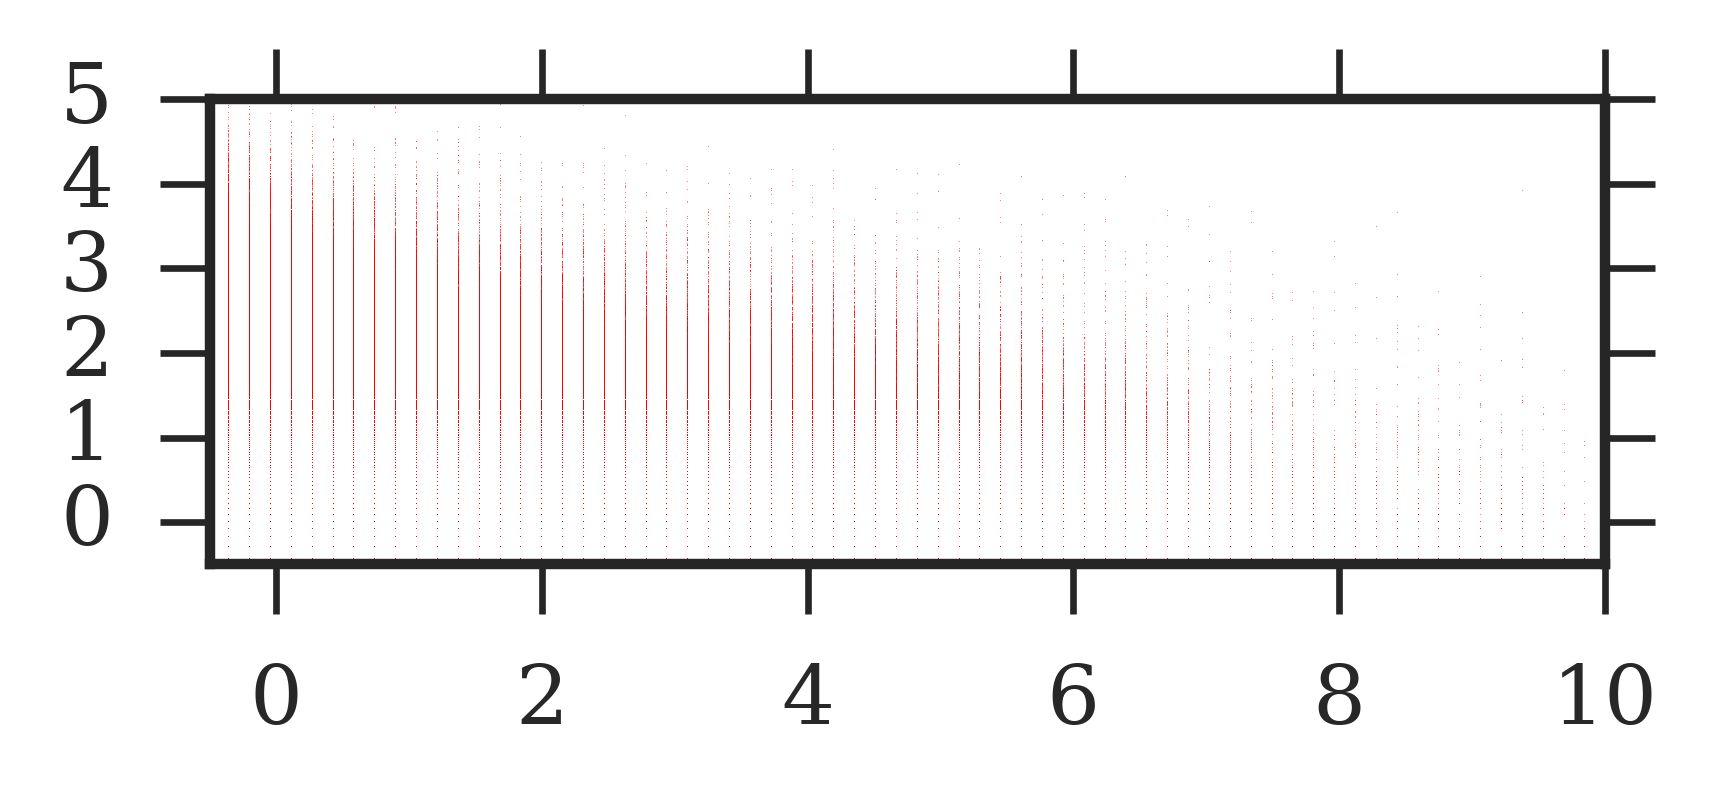

In [179]:
plt.close("all")
plt.clf()
plt.figure(figsize=(3,1))
#plt.plot(np.log10(df.TFirstP+1), np.log10(df.ncites + 1), "r,", alpha=0.5)
plt.plot(standardize(df.Pair_TFirstP), standardize(np.log10(df.ncites + 1)), "r,", alpha=0.5)
plt.xlim([-0.5,10])
plt.ylim([-0.5,5])

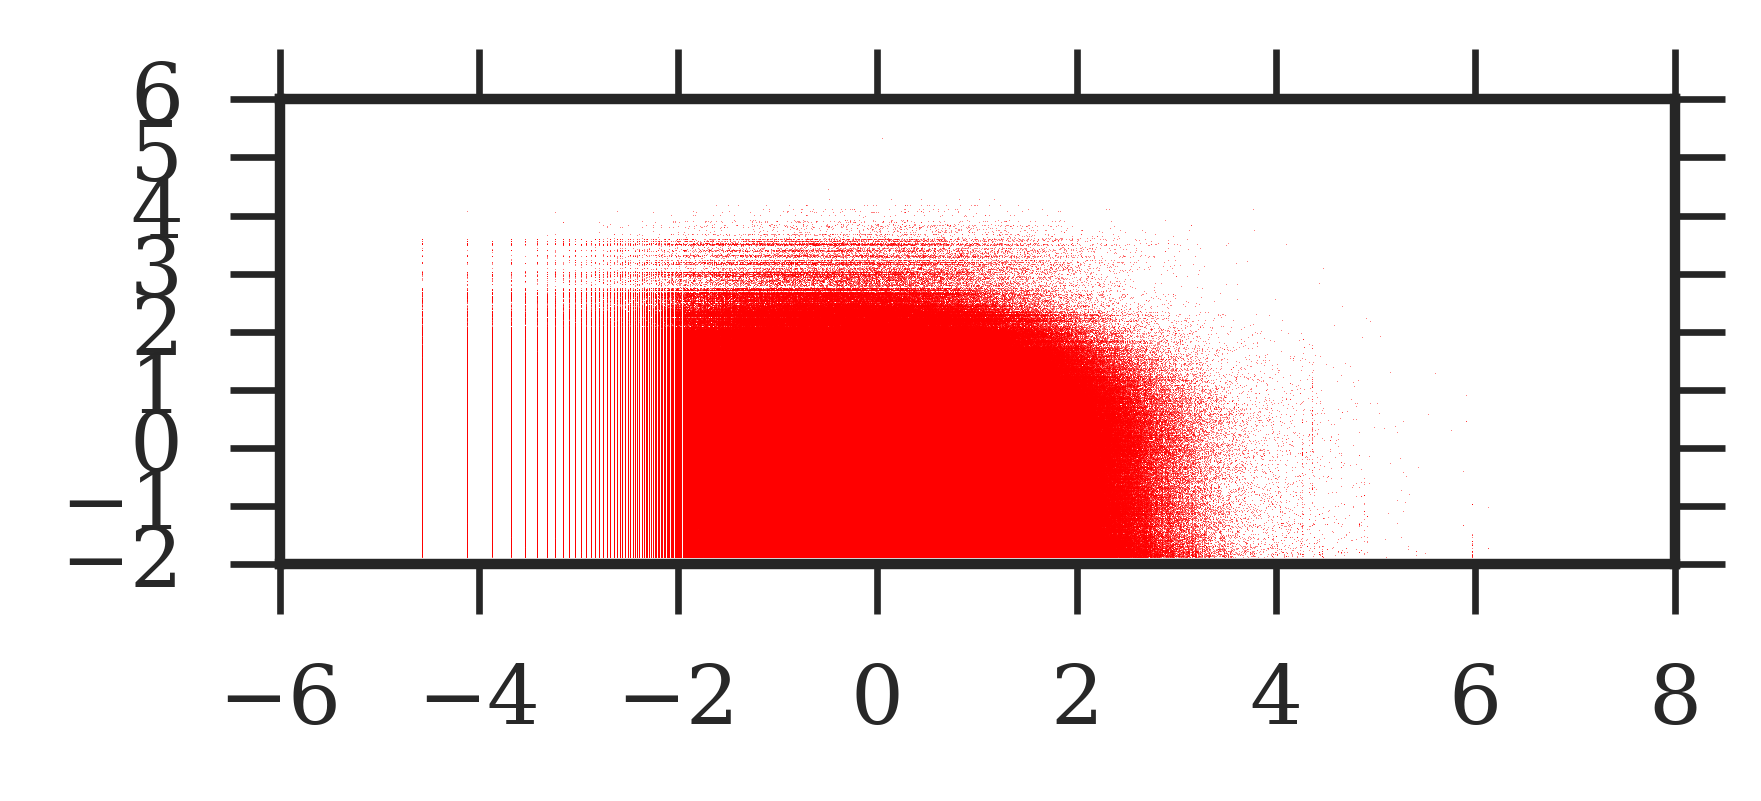

In [188]:
plt.close("all")
plt.clf()
plt.figure(figsize=(3,1))
#plt.plot(np.log10(df.TFirstP+1), np.log10(df.ncites + 1), "r,", alpha=0.5)
plt.plot(standardize(np.log10(df.VolFirstP)), standardize(np.log10(df.mean_cites+1)), "r,", alpha=0.5)
#plt.xlim([-0.5,10])
#plt.ylim([-0.5,5])

In [14]:
df.normed_cites.describe()

count    15993116.000000
mean            3.240938
std            23.463616
min             0.000050
25%             0.542608
50%             1.341915
75%             3.071111
max         28426.004204
Name: normed_cites, dtype: float64

In [21]:
from scipy.stats import binned_statistic

In [38]:
t = binned_statistic(df[df.year==1985].TFirstP, np.log10(df[df.year==1985].normed_cites),
                    statistic=np.mean, bins=range(60))

In [30]:
t

BinnedStatisticResult(statistic=array([ 0.21865713,  0.32630461,  0.27322545,  0.24385653,  0.14049143,
        0.11371183,  0.07576298,  0.02907035,  0.03692173,  0.02904919,
        0.0526952 ,  0.0304982 ,  0.03889303,  0.03289027,  0.01138078,
       -0.02229152,  0.0160336 ,  0.01671753, -0.00512417,  0.00398135,
       -0.01679625, -0.01646499, -0.01492815, -0.00673577, -0.03878014,
       -0.02806961, -0.02855367, -0.2679297 , -0.11873142, -0.09771115,
        0.07406747, -0.04844423, -0.01418753, -0.07279716, -0.01935712,
       -0.00613755, -0.04359556, -0.04650044, -0.03922946, -0.21302173,
       -0.32894049, -0.59990918, -0.18214468, -0.59226484,         nan,
       -0.37210596,         nan,  0.26234437,         nan, -0.68049419,
               nan,         nan,         nan, -0.53355494,         nan,
               nan,         nan, -0.82143223,         nan]), bin_edges=array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  

In [35]:
x = (t.bin_edges[:-1] + t.bin_edges[1:])*0.5
y = t.statistic
x,y

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
         45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
         54.5,  55.5,  56.5,  57.5,  58.5]),
 array([ 0.21865713,  0.32630461,  0.27322545,  0.24385653,  0.14049143,
         0.11371183,  0.07576298,  0.02907035,  0.03692173,  0.02904919,
         0.0526952 ,  0.0304982 ,  0.03889303,  0.03289027,  0.01138078,
        -0.02229152,  0.0160336 ,  0.01671753, -0.00512417,  0.00398135,
        -0.01679625, -0.01646499, -0.01492815, -0.00673577, -0.03878014,
        -0.02806961, -0.02855367, -0.2679297 , -0.11873142, -0.09771115,
         0.07406747, -0.04844423, -0.01418753, -0.07279716, -0.01935712,
        -0.0061375

In [46]:
def get_plot_data(x,y,bins=10):
    t = binned_statistic(x, y, statistic=np.mean, bins=bins)
    x = (t.bin_edges[:-1] + t.bin_edges[1:])*0.5
    y = t.statistic
    t = binned_statistic(x, y, statistic=lambda x: np.percentile(x, 25), bins=bins)
    l_err = t.statistic
    t = binned_statistic(x, y, statistic=lambda x: np.percentile(x, 75), bins=bins)
    h_err = t.statistic
    return x,y,(l_err,h_err)

<Container object of 3 artists>

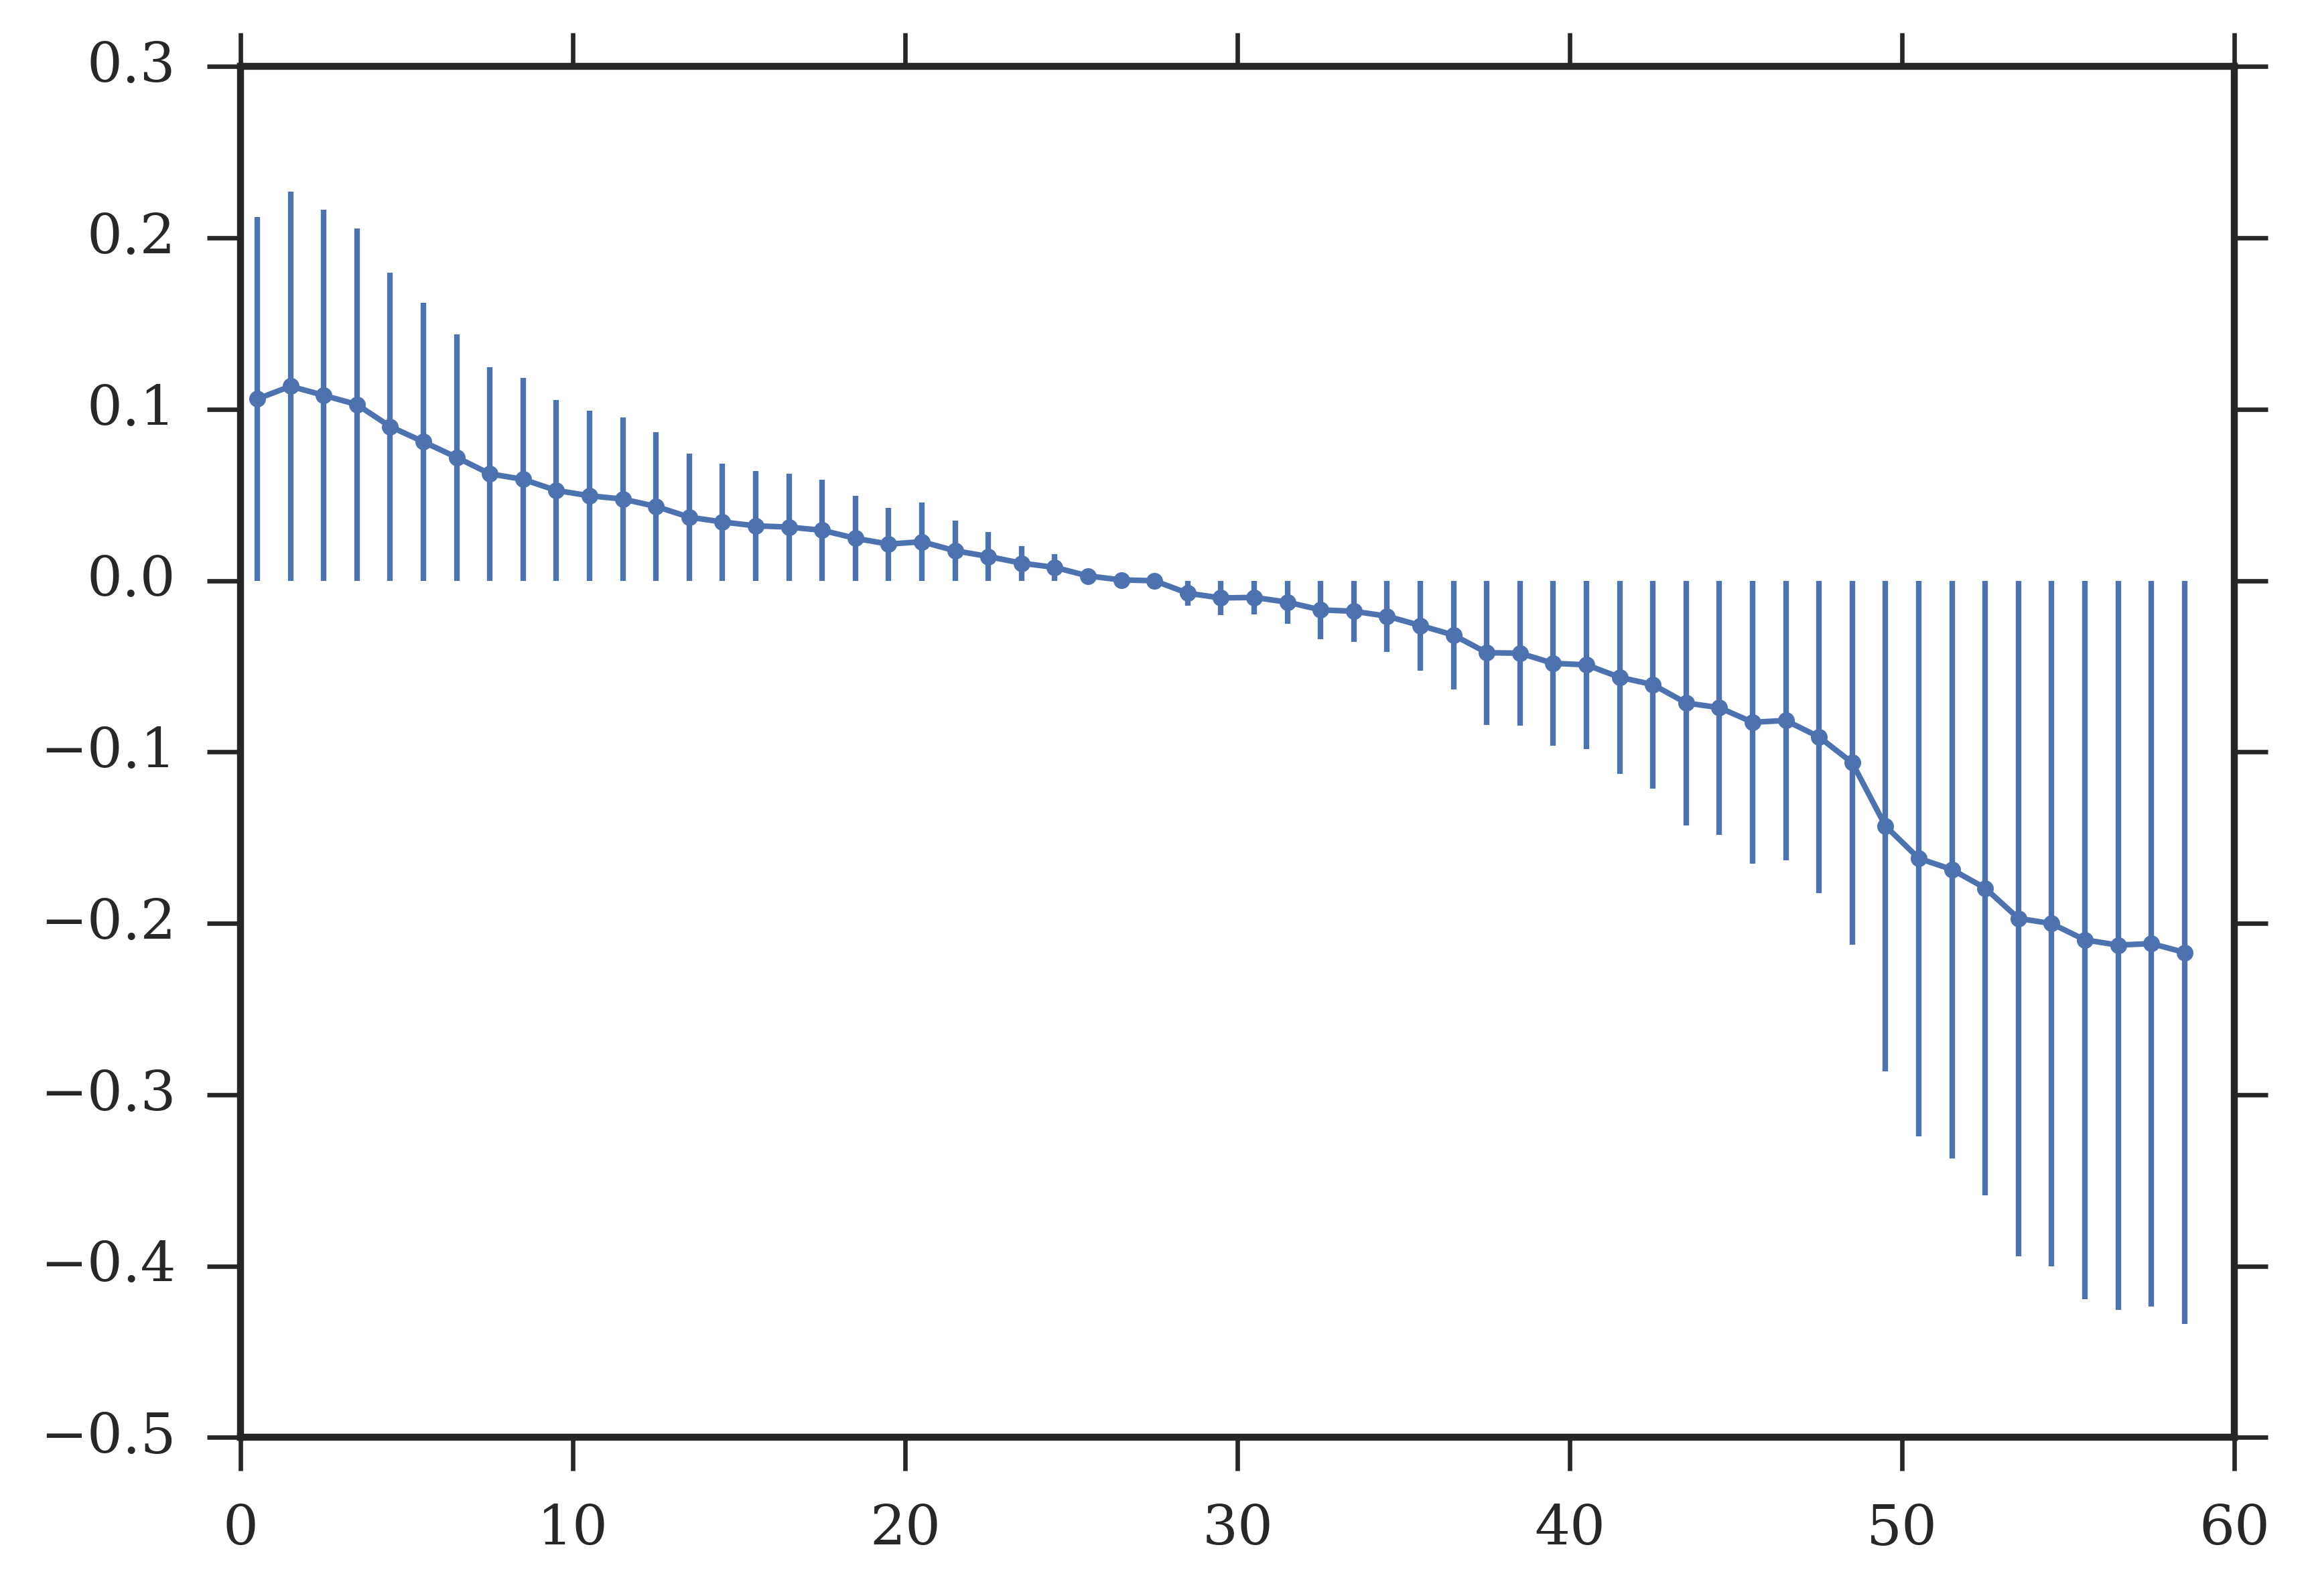

In [48]:
plt.close("all")
plt.clf()
x,y,err = get_plot_data(df.TFirstP, np.log10(df.normed_cites), bins=range(60))
plt.errorbar(x,y,yerr=err, marker="o")

In [67]:
from matplotlib.ticker import LinearLocator


Processing all 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1985 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1990 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1995 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2000 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2005 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2010 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP


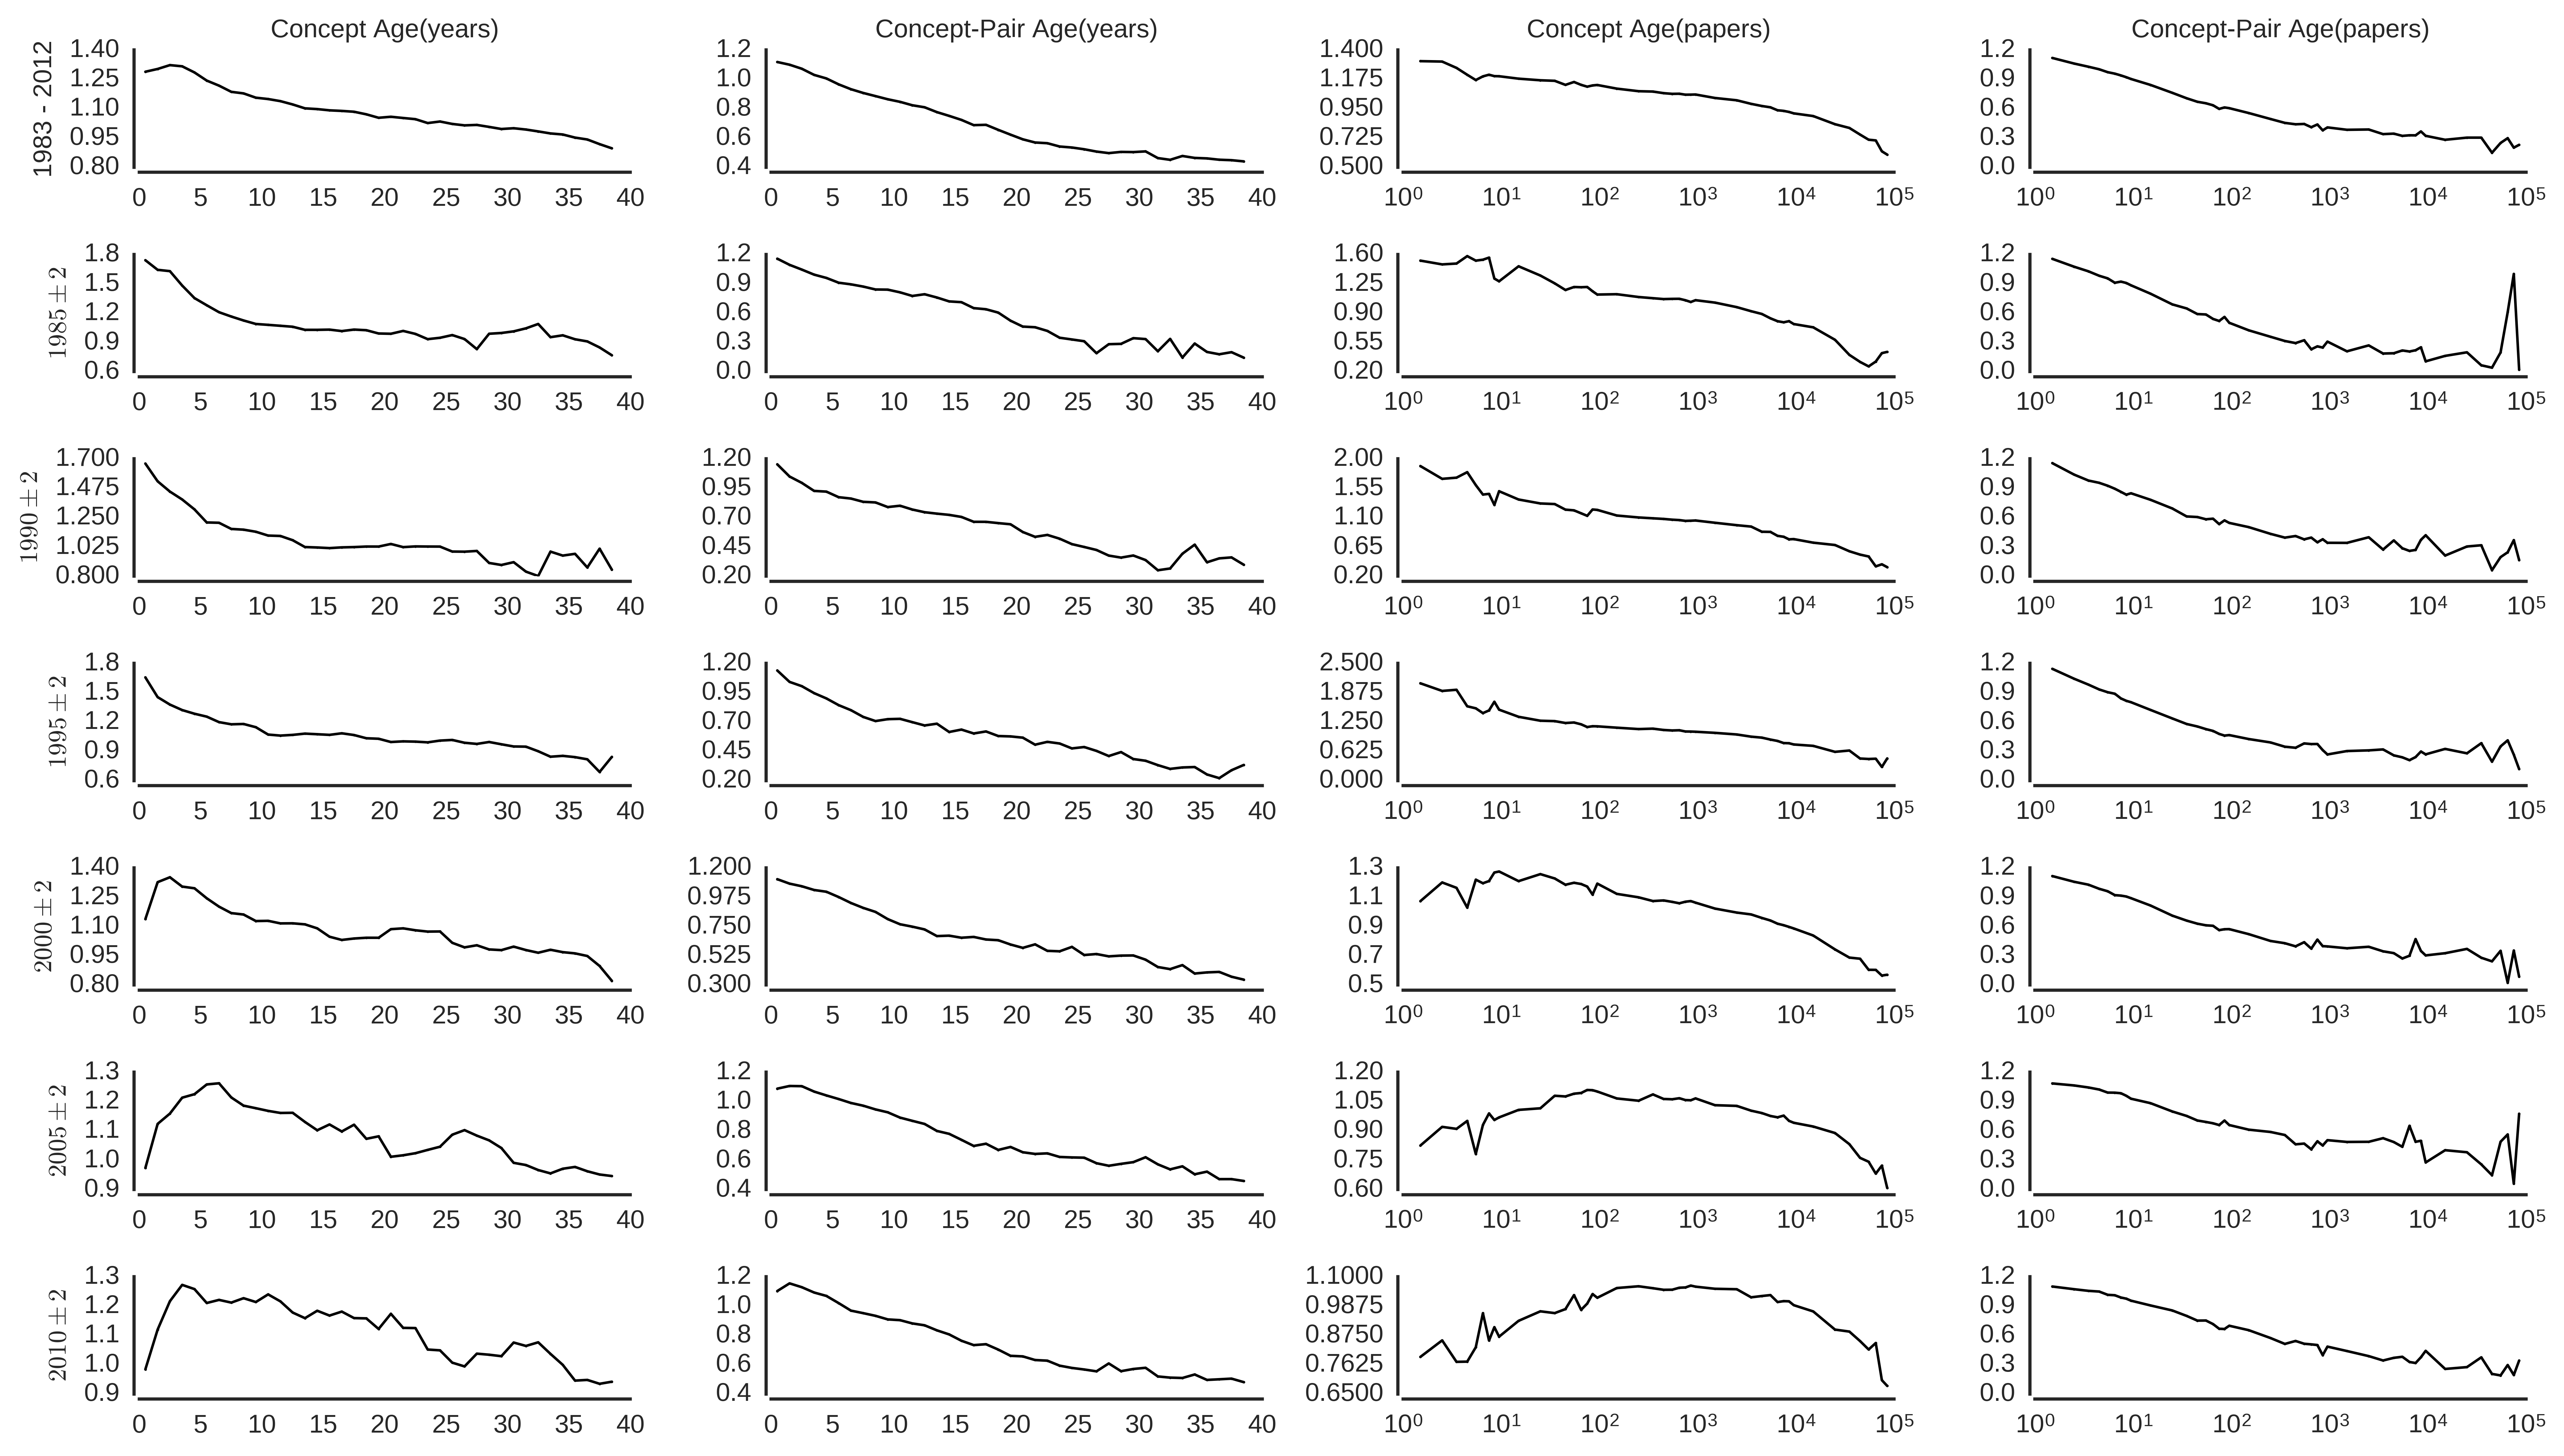

In [137]:
with sns.plotting_context("paper") and sns.axes_style("white"):
    filters = ["all"]
    filters = ["all"] + range(1985,2015,5)
    cols = ["TFirstP", "Pair_TFirstP", "VolFirstP", "Pair_VolFirstP"]
    xlabels = ["Concept Age(years)", "Concept-Pair Age(years)", "Concept Age(papers)", "Concept-Pair Age(papers)"]
    y_col = "normed_cites"
    bins = [np.arange(40), np.arange(40),
            reduce(lambda x,y: x+y, map(lambda i: range(i,i*10,i), 10**np.arange(5))),
            reduce(lambda x,y: x+y, map(lambda i: range(i,i*10,i), 10**np.arange(5)))]
    plt.close("all")
    plt.clf()
    fig, ax = plt.subplots(len(filters), len(cols),
                           #sharex="col", sharey="col",
                           sharex="col", sharey=False,
                           squeeze=False, figsize=(2*len(filters), 2*len(cols)))
    for i, flt in enumerate(filters):
        if i == 0:
            df_t = df[(df["year"] >=min(filters[1:])-2) & (df["year"] <=max(filters[1:])+2)].copy()
        else:
            df_t = df[(df["year"] >=flt-2) & (df["year"] <=flt+2)][cols + [y_col]].copy()
        print "\nProcessing %s" % flt,
        y_vals = np.log10(df_t[y_col])
        for j, c in enumerate(cols):
            print "\t%s" % c, 
            if i == 0:
                ax[i,j].xaxis.set_label_position('top')
                ax[i,j].set_xlabel(xlabels[j])
            if j == 0:
                if i == 0:
                    ax[i,j].set_ylabel("%s - %s" % (min(filters[1:])-2, max(filters[1:])+2))
                else:
                    ax[i,j].set_ylabel("$%s\pm2$" % flt)
            x,y,err = get_plot_data(df_t[c], y_vals, bins=bins[j])
            y = 10**y
            err = 10**err[0], 10**err[1]
            ax[i,j].plot(x,y, marker="o", color="black", ms=1,lw=1)
            #ax[i,j].errorbar(x,y, yerr=err, marker="o", color="black", ms=1,lw=1, elinewidth=1)
            ax[i,j].get_yaxis().set_major_locator(LinearLocator(numticks=5))
            #ax[i,j].spines['right'].set_visible(False)
            #ax[i,j].spines['top'].set_visible(False)
            if j >1:
                ax[i,j].set_xscale("log")
    sns.despine(offset=2, trim=True)
    fig.tight_layout()
    plt.savefig("plots/JCDL_WOSP/Normed_Cites_Novelty.pdf", bbox_inches="tight")


Processing all 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1985 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1990 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1995 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2000 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2005 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2010 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP


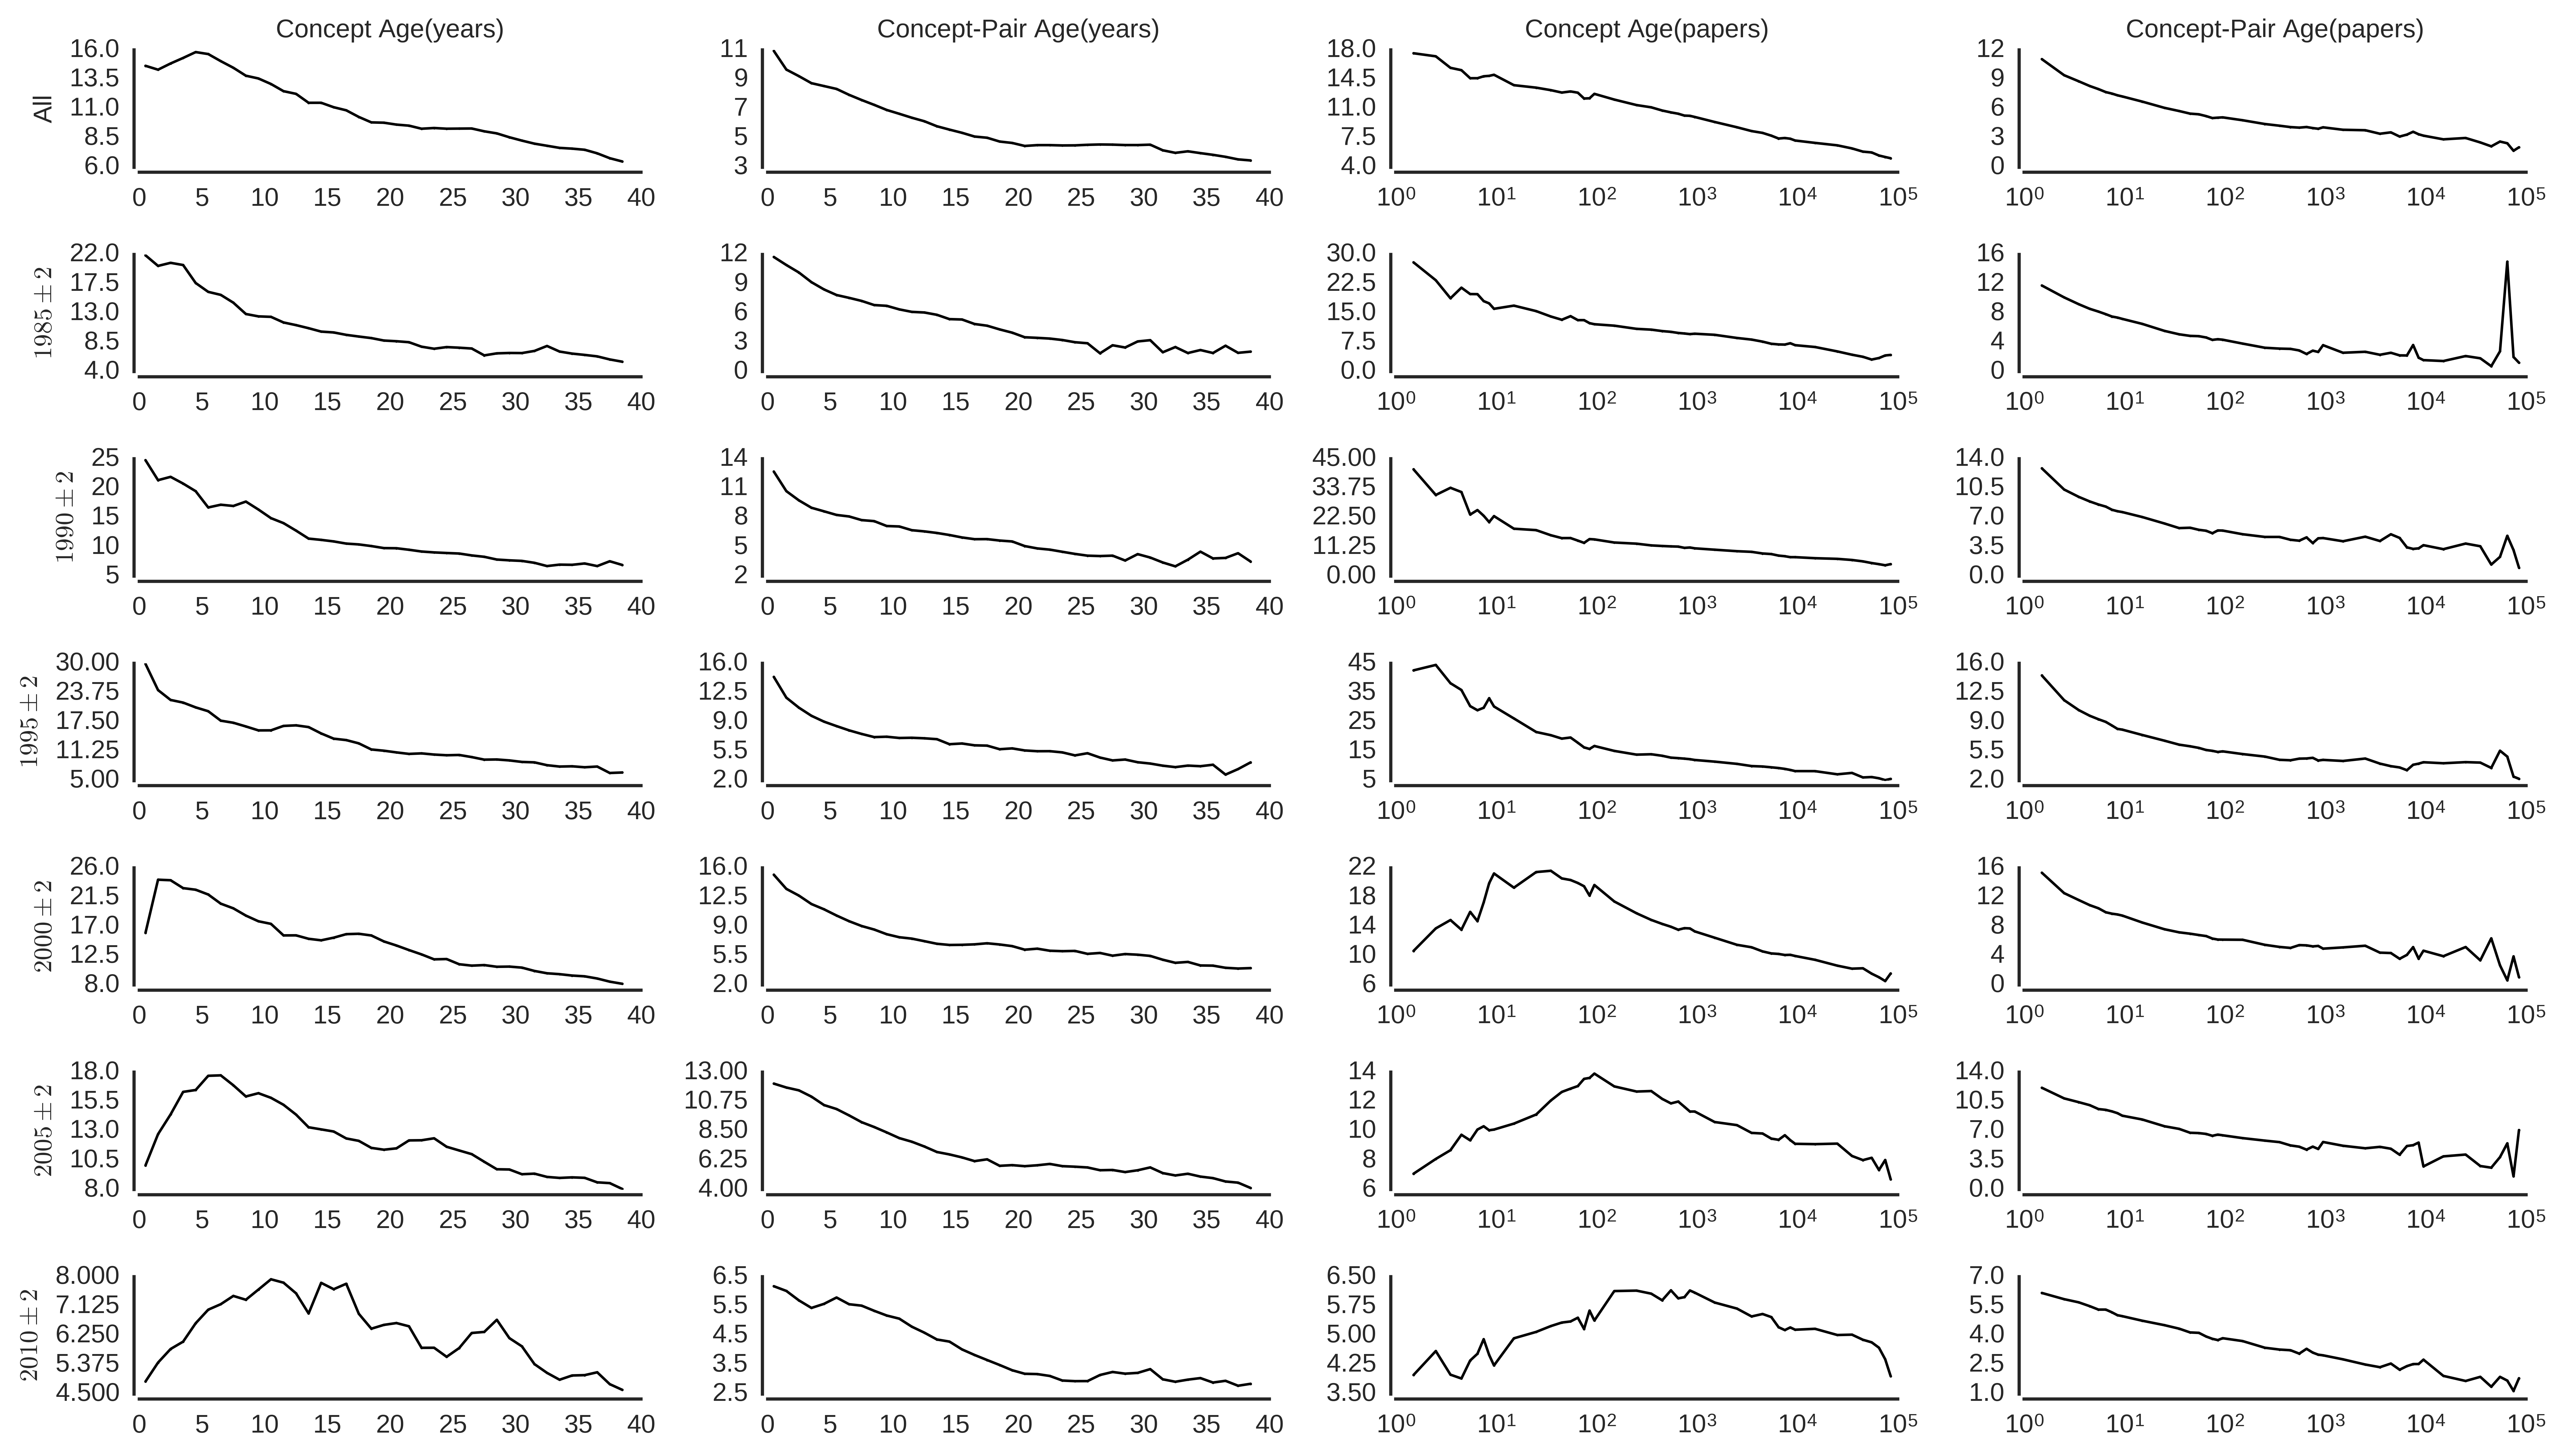

In [138]:
with sns.plotting_context("paper") and sns.axes_style("white"):
    filters = ["all"]
    filters = ["all"] + range(1985,2015,5)
    cols = ["TFirstP", "Pair_TFirstP", "VolFirstP", "Pair_VolFirstP"]
    xlabels = ["Concept Age(years)", "Concept-Pair Age(years)", "Concept Age(papers)", "Concept-Pair Age(papers)"]
    y_col = "ncites"
    bins = [np.arange(40), np.arange(40),
            reduce(lambda x,y: x+y, map(lambda i: range(i,i*10,i), 10**np.arange(5))),
            reduce(lambda x,y: x+y, map(lambda i: range(i,i*10,i), 10**np.arange(5)))]
    plt.close("all")
    plt.clf()
    fig, ax = plt.subplots(len(filters), len(cols),
                           #sharex="col", sharey="col",
                           sharex="col", sharey=False,
                           squeeze=False, figsize=(2*len(filters), 2*len(cols)))
    for i, flt in enumerate(filters):
        if flt == "all":
            df_t = df[(df["year"] >=min(filters[1:])-2) & (df["year"] <=max(filters[1:])+2)].copy()
        else:
            df_t = df[(df["year"] >=flt-2) & (df["year"] <=flt+2)][cols + [y_col]].copy()
        print "\nProcessing %s" % flt,
        y_vals = np.log10(df_t[y_col]+1)
        for j, c in enumerate(cols):
            print "\t%s" % c,
            if i == 0:
                ax[i,j].xaxis.set_label_position('top')
                ax[i,j].set_xlabel(xlabels[j])
            if j == 0:
                if i == 0:
                    ax[i,j].set_ylabel("All")
                else:
                    ax[i,j].set_ylabel("$%s\pm2$" % flt)
            x,y,err = get_plot_data(df_t[c], y_vals, bins=bins[j])
            y = 10**y-1
            err = 10**err[0]-1, 10**err[1]-1
            #ax[i,j].errorbar(x,y, yerr=err, marker="o", color="black", ms=1,lw=1, elinewidth=1)
            ax[i,j].plot(x,y, marker="o", color="black", ms=1,lw=1)
            ax[i,j].get_yaxis().set_major_locator(LinearLocator(numticks=5))
            #ax[i,j].plot(x,y, marker="o", ms=0.5,lw=1)
            #ax[i,j].get_yaxis().set_major_locator(LinearLocator(numticks=5))
            #ax[i,j].spines['right'].set_visible(False)
            #ax[i,j].spines['top'].set_visible(False)
            if j >1:
                ax[i,j].set_xscale("log")
    sns.despine(offset=2, trim=True)
    fig.tight_layout()
    plt.savefig("plots/JCDL_WOSP/Cites_Novelty.pdf", bbox_inches="tight")

In [141]:
import matplotlib.lines as mlines


Processing all 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1985 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1990 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 1995 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2000 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2005 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP 
Processing 2010 	TFirstP 	Pair_TFirstP 	VolFirstP 	Pair_VolFirstP


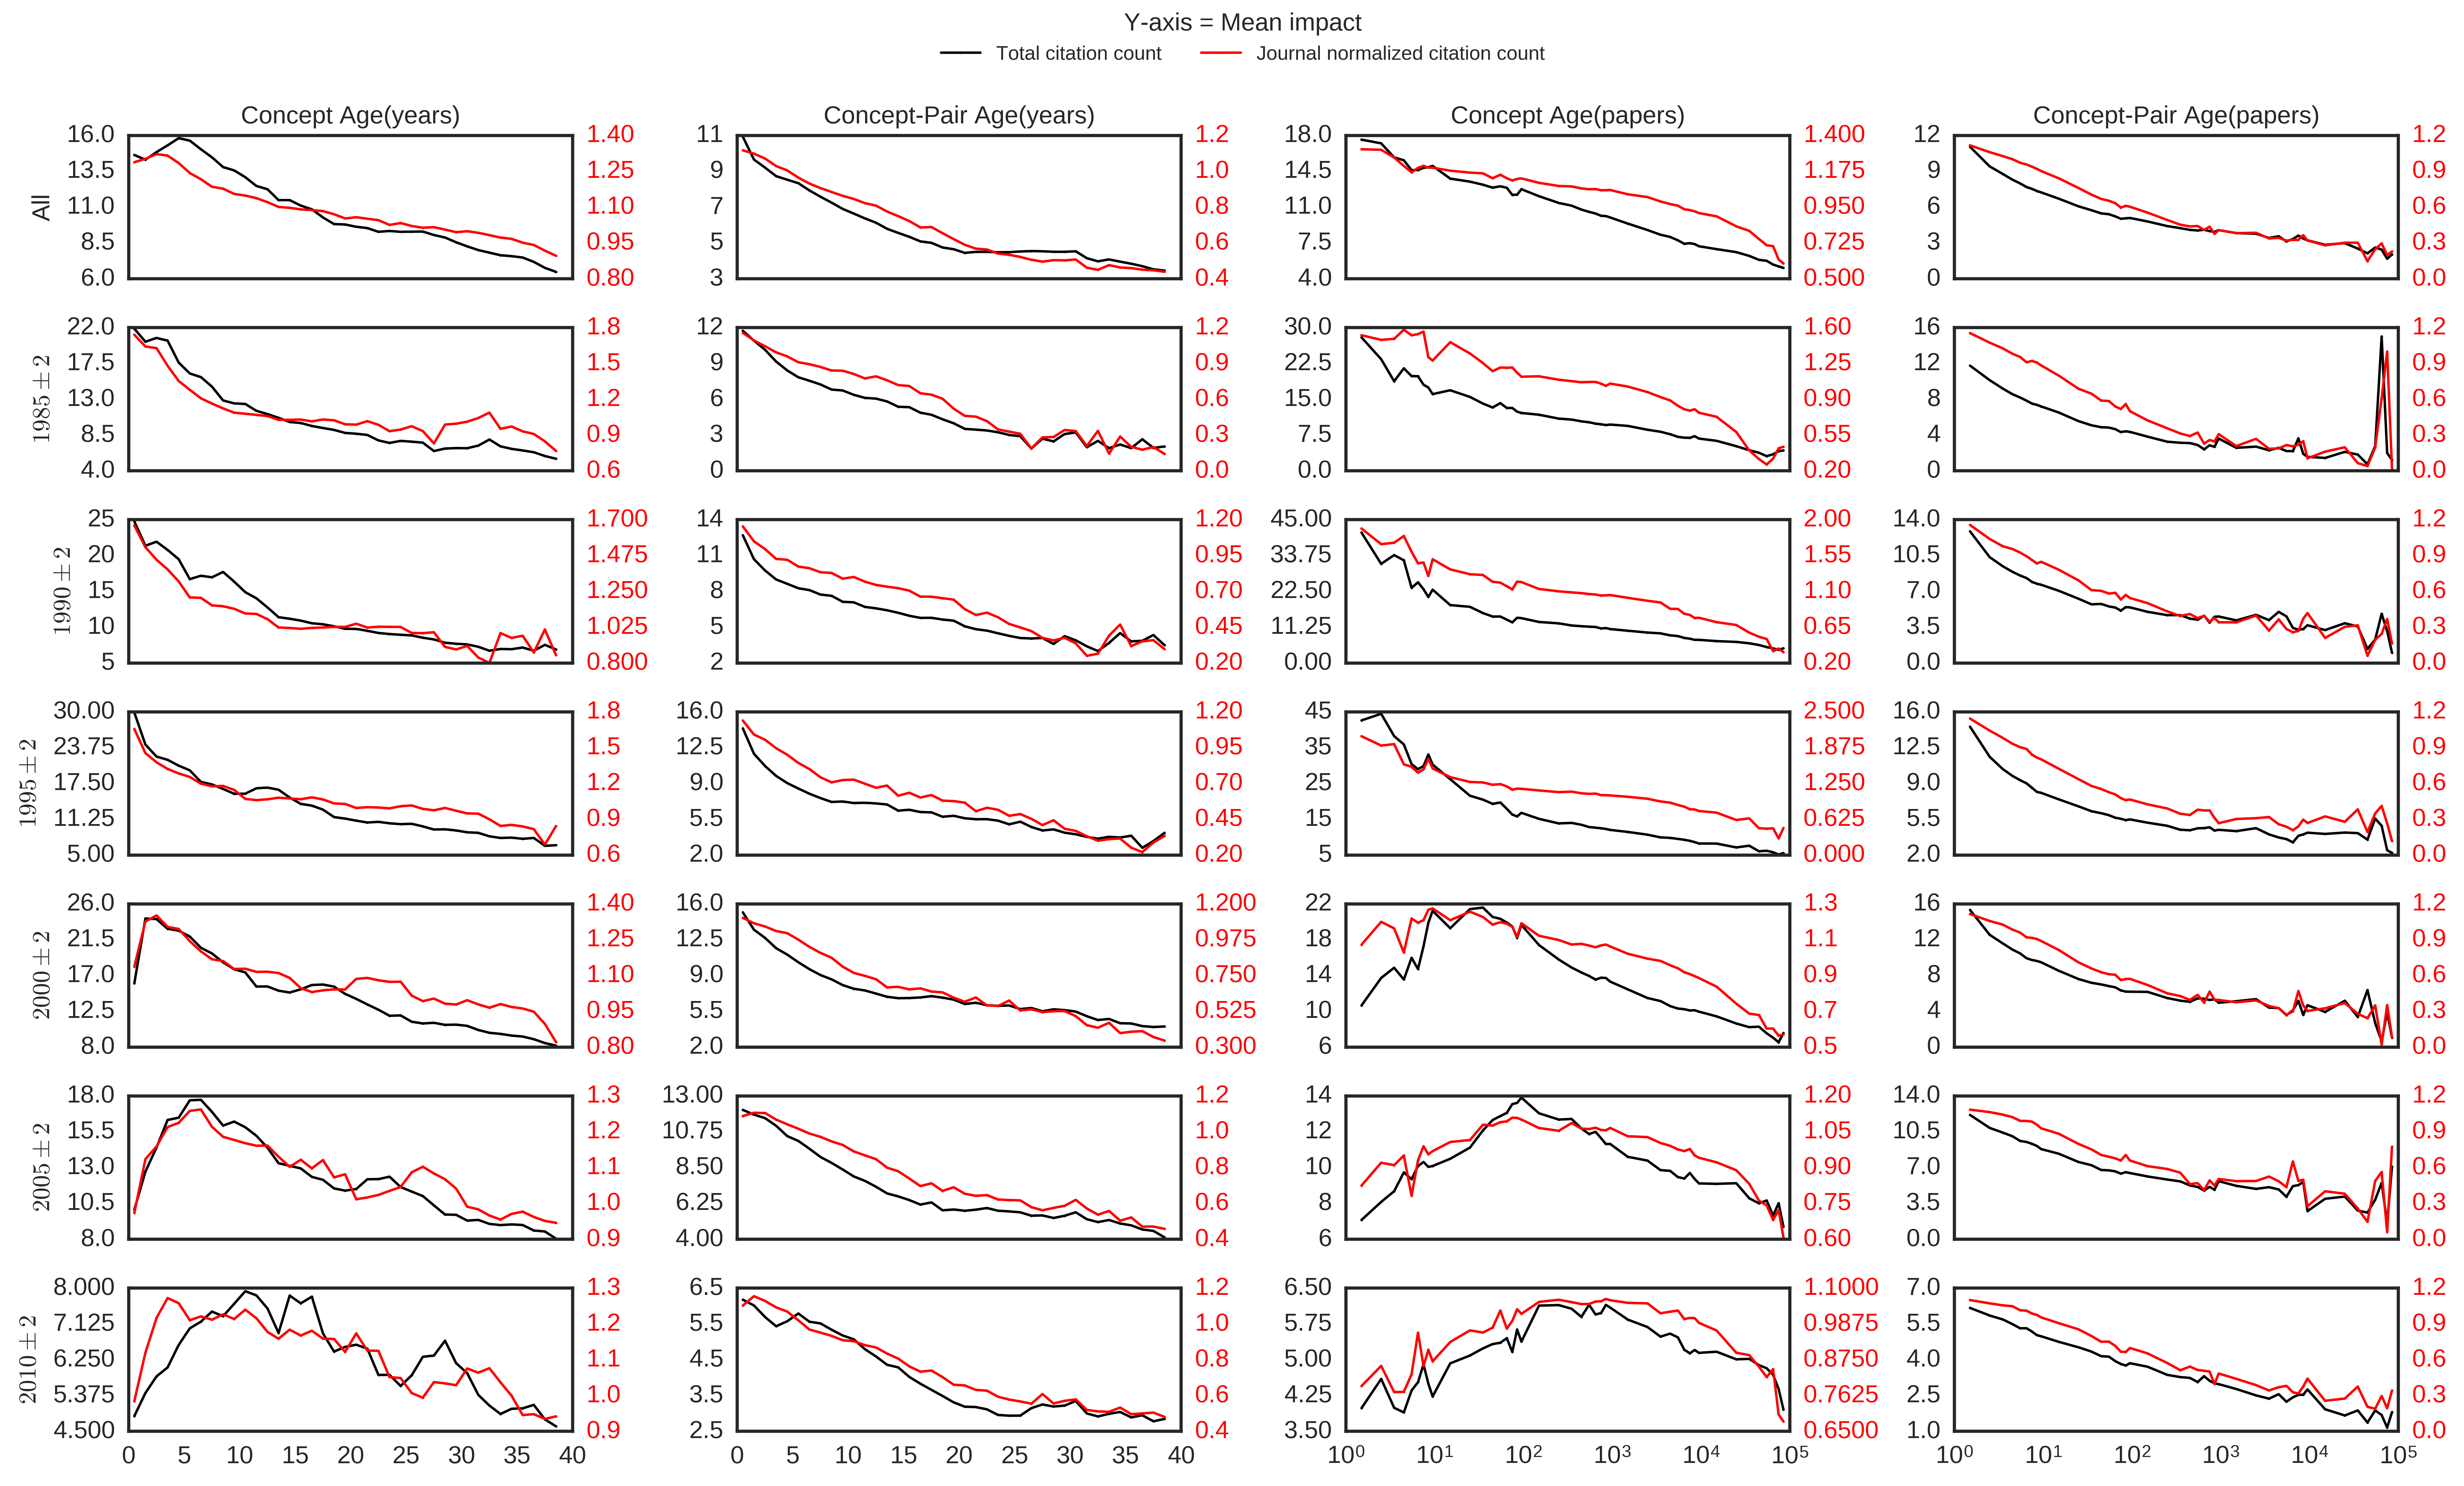

In [150]:
with sns.plotting_context("paper") and sns.axes_style("white"):
    filters = ["all"]
    filters = ["all"] + range(1985,2015,5)
    cols = ["TFirstP", "Pair_TFirstP", "VolFirstP", "Pair_VolFirstP"]
    xlabels = ["Concept Age(years)", "Concept-Pair Age(years)", "Concept Age(papers)", "Concept-Pair Age(papers)"]
    y_col = "ncites"
    y_col2 = "normed_cites"
    bins = [np.arange(40), np.arange(40),
            reduce(lambda x,y: x+y, map(lambda i: range(i,i*10,i), 10**np.arange(5))),
            reduce(lambda x,y: x+y, map(lambda i: range(i,i*10,i), 10**np.arange(5)))]
    plt.close("all")
    plt.clf()
    fig, ax = plt.subplots(len(filters), len(cols),
                           #sharex="col", sharey="col",
                           sharex="col", sharey=False,
                           squeeze=False, figsize=(2*len(filters), 2*len(cols)))
    for i, flt in enumerate(filters):
        if flt == "all":
            df_t = df[(df["year"] >=min(filters[1:])-2) & (df["year"] <=max(filters[1:])+2)][cols + [y_col, y_col2]].copy()
        else:
            df_t = df[(df["year"] >=flt-2) & (df["year"] <=flt+2)][cols + [y_col, y_col2]].copy()
        print "\nProcessing %s" % flt,
        y_vals = np.log10(df_t[y_col]+1)
        y_vals2 = np.log10(df_t[y_col2])
        for j, c in enumerate(cols):
            print "\t%s" % c,
            if i == 0:
                ax[i,j].xaxis.set_label_position('top')
                ax[i,j].set_xlabel(xlabels[j])
            if j == 0:
                if i == 0:
                    ax[i,j].set_ylabel("All")
                else:
                    ax[i,j].set_ylabel("$%s\pm2$" % flt)
            x,y,err = get_plot_data(df_t[c], y_vals, bins=bins[j])
            y = 10**y-1
            err = 10**err[0]-1, 10**err[1]-1
            ax[i,j].plot(x,y, marker="o", color="black", ms=1,lw=1)
            ax[i,j].get_yaxis().set_major_locator(LinearLocator(numticks=5))
            
            ax2 = ax[i,j].twinx()
            x,y,err = get_plot_data(df_t[c], y_vals2, bins=bins[j])
            y = 10**y
            err = 10**err[0], 10**err[1]
            ax2.plot(x,y, marker="o", color="red", ms=1,lw=1)
            ax2.get_yaxis().set_major_locator(LinearLocator(numticks=5))
            for tl in ax2.get_yticklabels():
                tl.set_color('r')
            if j >1:
                ax[i,j].set_xscale("log")                
    #sns.despine(offset=2, trim=True)
    black_line = plt.Line2D([], [], color='black', marker='o',
                          markersize=1)
    red_line = plt.Line2D([], [], color='red', marker='o',
                          markersize=1)
    lgd = fig.legend(handles=[black_line, red_line],
                     labels=["Total citation count", "Journal normalized citation count"],
                     loc = 'upper center',bbox_to_anchor=(0.5, 1.05),
                     title = "Y-axis = Mean impact",
                     ncol=2, frameon=False, fancybox=False)
    fig.tight_layout()
    plt.savefig("plots/JCDL_WOSP/Cites_Novelty_both.pdf", bbox_inches="tight", bbox_extra_artists=[lgd])

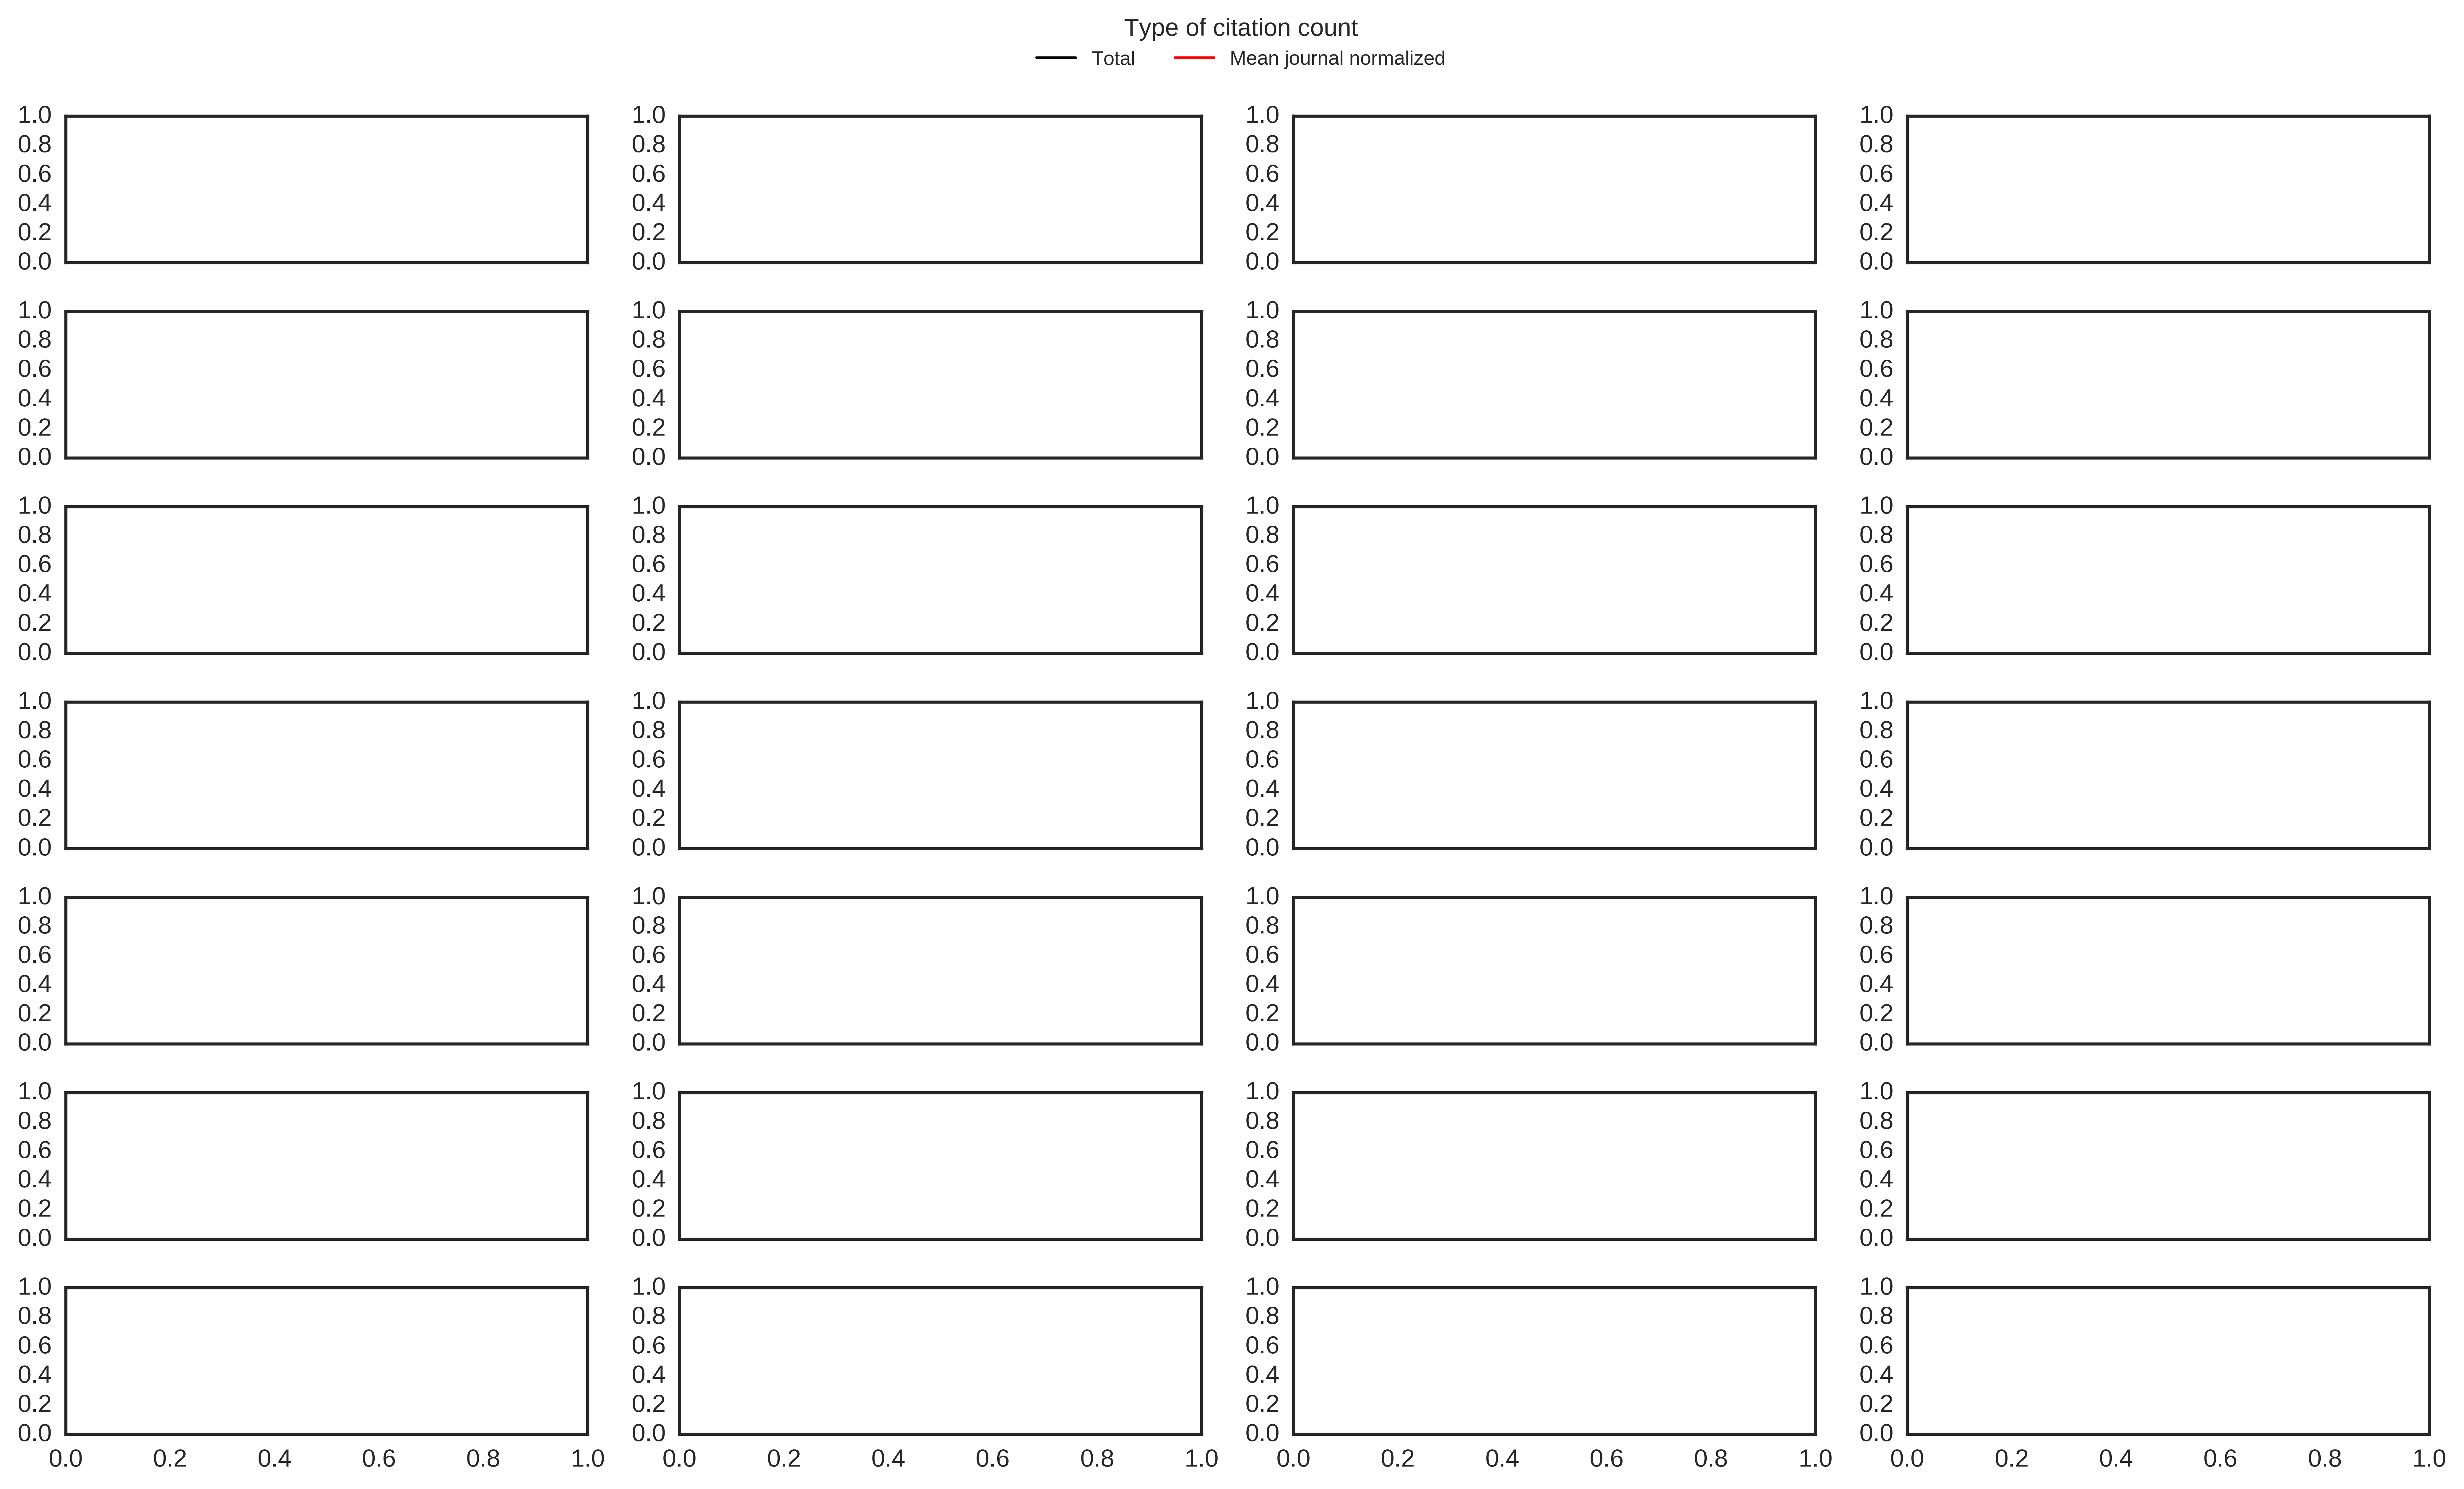

In [146]:
with sns.plotting_context("paper") and sns.axes_style("white"):
    filters = ["all"]
    filters = ["all"] + range(1985,2015,5)
    cols = ["TFirstP", "Pair_TFirstP", "VolFirstP", "Pair_VolFirstP"]
    xlabels = ["Concept Age(years)", "Concept-Pair Age(years)", "Concept Age(papers)", "Concept-Pair Age(papers)"]
    y_col = "ncites"
    y_col2 = "normed_cites"
    bins = [np.arange(40), np.arange(40),
            reduce(lambda x,y: x+y, map(lambda i: range(i,i*10,i), 10**np.arange(5))),
            reduce(lambda x,y: x+y, map(lambda i: range(i,i*10,i), 10**np.arange(5)))]
    plt.close("all")
    plt.clf()
    fig, ax = plt.subplots(len(filters), len(cols),
                           #sharex="col", sharey="col",
                           sharex="col", sharey=False,
                           squeeze=False, figsize=(2*len(filters), 2*len(cols)))
    black_line = plt.Line2D([], [], color='black', marker='o',
                          markersize=1, label='Total')
    red_line = plt.Line2D([], [], color='red', marker='o',
                          markersize=1, label='Mean journal normalized')
    lgd = fig.legend(handles=[black_line, red_line], labels=["Total", "Mean journal normalized"],
        loc = 'upper center',bbox_to_anchor=(0.5, 1.05),
        title = "Type of citation count",
        ncol=2, frameon=False, fancybox=False)
    fig.tight_layout()

## Modelling novelty versus citation using regression

In [151]:
from statsmodels.formula.api import ols

In [152]:
log_1 = lambda x: np.log10(x+1)
is_missing = lambda x: np.isnan(x)
is_not_missing = lambda x: ~np.isnan(x)
is_k = lambda x,k: x == k
power_k = lambda x,k: x**k
fill_k = lambda x,k: x.fillna(k)
sub_k = lambda x,k: x - k
mul_k = lambda x,k: x*k
standardize = lambda x: (x-x.mean())/(x.std() if x.shape[0] > 1 else 1)

In [153]:
df.columns

Index([u'pmid', u'year', u'TFirstP', u'VolFirstP', u'Pair_TFirstP', u'Pair_VolFirstP', u'num_mesh', u'num_ex_mesh', u'mean_cites', u'ncites', u'normed_cites'], dtype='object')

In [210]:
Timeformula = ("log_1(ncites) ~ I(sub_k(year,2000)/15)*(log_1(TFirstP) + log_1(fill_k(Pair_TFirstP,0))+is_missing(Pair_TFirstP))"
              "+ I(sub_k(year,2000)/15) + power_k(num_mesh, 0.5)")

In [211]:
model = ols(formula=Timeformula, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Ordinary least squares
============================================================================================================
Model:                            OLS                          Adj. R-squared:                 0.155        
Dependent Variable:               log_1(ncites)                AIC:                            20193047.7911
Date:                             2016-04-27 21:33             BIC:                            20193176.9825
No. Observations:                 12668153                     Log-Likelihood:                 -1.0097e+07  
Df Model:                         8                            F-statistic:                    2.912e+05    
Df Residuals:                     12668144                     Prob (F-statistic):             0.00         
R-squared:                        0.155                        Scale:                          0.28826      
------------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                                   0.5389   0.0013  421.4851 0.0000  0.5364  0.5414
is_missing(Pair_TFirstP)[T.True]                            0.1837   0.0100   18.4093 0.0000  0.1641  0.2033
I(sub_k(year, 2000) / 15)                                  -0.3423   0.0013 -268.5271 0.0000 -0.3448 -0.3398
I(sub_k(year, 2000) / 15):is_missing(Pair_TFirstP)[T.True]  0.1658   0.0168    9.8829 0.0000  0.1329  0.1986
log_1(TFirstP)                                             -0.1971   0.0006 -322.5855 0.0000 -0.1982 -0.1959
log_1(fill_k(Pair_TFirstP, 0))                              0.0121   0.0004   28.7141 0.0000  0.0112  0.0129
I(sub_k(year, 2000) / 15):log_1(TFirstP)                    0.0166   0.0010   16.0580 0.0000  0.0146  0.0187
I(sub_k(year, 2000) / 15):log_1(fill_k(Pair_TFirstP, 0))    0.0834   0.0007  127.1707 0.0000  0.0822  0.0847
power_k(num_mesh, 0.5)                                      0.2163   0.0003  829.5418 0.0000  0.2158  0.2168
------------------------------------------------------------------------------------------------------------
Omnibus:                         131568.617                   Durbin-Watson:                      1.938     
Prob(Omnibus):                   0.000                        Jarque-Bera (JB):                   132970.252
Skew:                            0.240                        Prob(JB):                           0.000     
Kurtosis:                        2.852                        Condition No.:                      423       
============================================================================================================

"""

In [214]:
Timeformula_j = ("log_1(ncites) ~ I(sub_k(year,2000)/15)*(log_1(TFirstP) + log_1(fill_k(Pair_TFirstP,0))) +is_missing(Pair_TFirstP)"
              "+ I(sub_k(year,2000)/15) + power_k(num_mesh, 0.5) + log_1(mean_cites)")

In [215]:
model = ols(formula=Timeformula_j, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
==========================================================================================================
Model:                          OLS                          Adj. R-squared:                 0.473        
Dependent Variable:             log_1(ncites)                AIC:                            14212151.7173
Date:                           2016-04-27 21:37             BIC:                            14212280.9087
No. Observations:               12668153                     Log-Likelihood:                 -7.1061e+06  
Df Model:                       8                            F-statistic:                    1.422e+06    
Df Residuals:                   12668144                     Prob (F-statistic):             0.00         
R-squared:                      0.473                        Scale:                          0.17978      
----------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                                -0.0244   0.0010  -23.6635 0.0000 -0.0264 -0.0224
is_missing(Pair_TFirstP)[T.True]                          0.0194   0.0077    2.5075 0.0122  0.0042  0.0345
I(sub_k(year, 2000) / 15)                                -0.0469   0.0010  -46.3088 0.0000 -0.0489 -0.0449
log_1(TFirstP)                                           -0.0597   0.0005 -123.1308 0.0000 -0.0607 -0.0588
log_1(fill_k(Pair_TFirstP, 0))                            0.0085   0.0003   25.7233 0.0000  0.0079  0.0092
I(sub_k(year, 2000) / 15):log_1(TFirstP)                 -0.0006   0.0008   -0.6973 0.4856 -0.0022  0.0010
I(sub_k(year, 2000) / 15):log_1(fill_k(Pair_TFirstP, 0))  0.0517   0.0005   99.6938 0.0000  0.0506  0.0527
power_k(num_mesh, 0.5)                                    0.1106   0.0002  528.2297 0.0000  0.1102  0.1111
log_1(mean_cites)                                         0.8213   0.0003 2764.7780 0.0000  0.8208  0.8219
----------------------------------------------------------------------------------------------------------
Omnibus:                         192302.657                  Durbin-Watson:                     2.000     
Prob(Omnibus):                   0.000                       Jarque-Bera (JB):                  288983.117
Skew:                            0.170                       Prob(JB):                          0.000     
Kurtosis:                        3.657                       Condition No.:                     250       
==========================================================================================================

"""

In [158]:
Volformula = ("log_1(ncites) ~ np.log10(VolFirstP) + log_1(fill_k(Pair_VolFirstP,0))+is_missing(Pair_VolFirstP)"
              "+ standardize(year) + power_k(num_mesh, 0.5)")

In [159]:
model = ols(formula=Volformula, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:                   OLS                   Adj. R-squared:          0.146        
Dependent Variable:      log_1(ncites)         AIC:                     20327752.8821
Date:                    2016-04-27 02:50      BIC:                     20327839.0097
No. Observations:        12668153              Log-Likelihood:          -1.0164e+07  
Df Model:                5                     F-statistic:             4.342e+05    
Df Residuals:            12668147              Prob (F-statistic):      0.00         
R-squared:               0.146                 Scale:                   0.29135      
-------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
Intercept                           0.1754   0.0013   134.5959 0.0000  0.1728  0.1779
is_missing(Pair_VolFirstP)[T.True]  0.2278   0.0098    23.1548 0.0000  0.2085  0.2471
np.log10(VolFirstP)                -0.0119   0.0003   -44.3797 0.0000 -0.0125 -0.0114
log_1(fill_k(Pair_VolFirstP, 0))    0.0281   0.0004    66.8282 0.0000  0.0272  0.0289
standardize(year)                  -0.1689   0.0002 -1073.7099 0.0000 -0.1692 -0.1685
power_k(num_mesh, 0.5)              0.2415   0.0003   919.7610 0.0000  0.2410  0.2421
-------------------------------------------------------------------------------------
Omnibus:                  137250.688           Durbin-Watson:              1.942     
Prob(Omnibus):            0.000                Jarque-Bera (JB):           138542.983
Skew:                     0.244                Prob(JB):                   0.000     
Kurtosis:                 2.844                Condition No.:              309       
=====================================================================================

"""

In [160]:
Volformula_j = ("log_1(ncites) ~ np.log10(VolFirstP) + log_1(fill_k(Pair_VolFirstP,0))+is_missing(Pair_VolFirstP)"
              "+ standardize(year) + power_k(num_mesh, 0.5)+ log_1(mean_cites)")

In [161]:
model = ols(formula=Volformula_j, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
====================================================================================
Model:                    OLS                  Adj. R-squared:         0.472        
Dependent Variable:       log_1(ncites)        AIC:                    14235131.6391
Date:                     2016-04-27 02:51     BIC:                    14235232.1213
No. Observations:         12668153             Log-Likelihood:         -7.1176e+06  
Df Model:                 6                    F-statistic:            1.889e+06    
Df Residuals:             12668146             Prob (F-statistic):     0.00         
R-squared:                0.472                Scale:                  0.18011      
------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------------
Intercept                          -0.1803   0.0010 -174.6746 0.0000 -0.1823 -0.1783
is_missing(Pair_VolFirstP)[T.True]  0.0192   0.0077    2.4809 0.0131  0.0040  0.0344
np.log10(VolFirstP)                 0.0094   0.0002   44.3848 0.0000  0.0090  0.0098
log_1(fill_k(Pair_VolFirstP, 0))    0.0163   0.0003   49.2079 0.0000  0.0156  0.0169
standardize(year)                  -0.0195   0.0001 -144.6728 0.0000 -0.0198 -0.0192
power_k(num_mesh, 0.5)              0.1204   0.0002  570.6118 0.0000  0.1200  0.1208
log_1(mean_cites)                   0.8269   0.0003 2797.1015 0.0000  0.8263  0.8274
------------------------------------------------------------------------------------
Omnibus:                 188189.907           Durbin-Watson:              2.000     
Prob(Omnibus):           0.000                Jarque-Bera (JB):           285467.530
Skew:                    0.163                Prob(JB):                   0.000     
Kurtosis:                3.659                Condition No.:              314       
====================================================================================

"""

In [162]:
FullFormula = ("log_1(ncites) ~ np.log10(VolFirstP) + log_1(fill_k(Pair_VolFirstP,0))+is_missing(Pair_VolFirstP)"
               "+ log_1(TFirstP) + log_1(fill_k(Pair_TFirstP,0))"
              "+ standardize(year) + power_k(num_mesh, 0.5)+ log_1(mean_cites)")

In [163]:
model = ols(formula=FullFormula, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
====================================================================================
Model:                    OLS                  Adj. R-squared:         0.474        
Dependent Variable:       log_1(ncites)        AIC:                    14201820.5124
Date:                     2016-04-27 02:52     BIC:                    14201949.7038
No. Observations:         12668153             Log-Likelihood:         -7.1009e+06  
Df Model:                 8                    F-statistic:            1.425e+06    
Df Residuals:             12668144             Prob (F-statistic):     0.00         
R-squared:                0.474                Scale:                  0.17964      
------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------------
Intercept                          -0.1050   0.0011  -93.5518 0.0000 -0.1072 -0.1028
is_missing(Pair_VolFirstP)[T.True]  0.0046   0.0077    0.5973 0.5503 -0.0105  0.0198
np.log10(VolFirstP)                 0.0306   0.0002  126.8210 0.0000  0.0301  0.0311
log_1(fill_k(Pair_VolFirstP, 0))    0.0243   0.0004   54.4312 0.0000  0.0235  0.0252
log_1(TFirstP)                     -0.0878   0.0005 -173.4324 0.0000 -0.0888 -0.0868
log_1(fill_k(Pair_TFirstP, 0))     -0.0110   0.0004  -24.5678 0.0000 -0.0119 -0.0101
standardize(year)                  -0.0188   0.0001 -140.0484 0.0000 -0.0191 -0.0186
power_k(num_mesh, 0.5)              0.1133   0.0002  525.5400 0.0000  0.1129  0.1137
log_1(mean_cites)                   0.8211   0.0003 2765.0693 0.0000  0.8205  0.8216
------------------------------------------------------------------------------------
Omnibus:                 185459.661           Durbin-Watson:              2.000     
Prob(Omnibus):           0.000                Jarque-Bera (JB):           280872.078
Skew:                    0.162                Prob(JB):                   0.000     
Kurtosis:                3.654                Condition No.:              326       
====================================================================================

"""

In [200]:
FullFormula = ("log_1(ncites) ~ np.log10(VolFirstP) + log_1(fill_k(Pair_VolFirstP,0))"
               "+ log_1(TFirstP) + power_k(log_1(TFirstP),2) + log_1(fill_k(Pair_TFirstP,0))"
              "+ standardize(year) + power_k(num_mesh, 0.5)+ log_1(mean_cites)")

In [201]:
model = ols(formula=FullFormula, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
==================================================================================
Model:                  OLS                  Adj. R-squared:         0.474        
Dependent Variable:     log_1(ncites)        AIC:                    14201561.3678
Date:                   2016-04-27 21:18     BIC:                    14201690.5593
No. Observations:       12668153             Log-Likelihood:         -7.1008e+06  
Df Model:               8                    F-statistic:            1.425e+06    
Df Residuals:           12668144             Prob (F-statistic):     0.00         
R-squared:              0.474                Scale:                  0.17963      
----------------------------------------------------------------------------------
                                  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                        -0.0867   0.0016  -54.4585 0.0000 -0.0899 -0.0836
np.log10(VolFirstP)               0.0312   0.0002  127.9240 0.0000  0.0307  0.0316
log_1(fill_k(Pair_VolFirstP, 0))  0.0239   0.0004   53.4295 0.0000  0.0230  0.0248
log_1(TFirstP)                   -0.1261   0.0024  -51.9162 0.0000 -0.1309 -0.1213
power_k(log_1(TFirstP), 2)        0.0161   0.0010   16.1091 0.0000  0.0142  0.0181
log_1(fill_k(Pair_TFirstP, 0))   -0.0115   0.0004  -25.7493 0.0000 -0.0124 -0.0107
standardize(year)                -0.0192   0.0001 -140.8866 0.0000 -0.0194 -0.0189
power_k(num_mesh, 0.5)            0.1136   0.0002  525.7522 0.0000  0.1132  0.1141
log_1(mean_cites)                 0.8212   0.0003 2763.5724 0.0000  0.8207  0.8218
----------------------------------------------------------------------------------
Omnibus:                 185283.745          Durbin-Watson:             2.000     
Prob(Omnibus):           0.000               Jarque-Bera (JB):          280612.511
Skew:                    0.161               Prob(JB):                  0.000     
Kurtosis:                3.654               Condition No.:             131       
==================================================================================

"""

In [164]:
TOnly = ("log_1(ncites) ~ log_1(TFirstP)")

In [165]:
model = ols(formula=TOnly, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
======================================================================
Model:              OLS              Adj. R-squared:     0.046        
Dependent Variable: log_1(ncites)    AIC:                21740415.9080
Date:               2016-04-27 02:52 BIC:                21740444.6172
No. Observations:   12668153         Log-Likelihood:     -1.0870e+07  
Df Model:           1                F-statistic:        6.051e+05    
Df Residuals:       12668151         Prob (F-statistic): 0.00         
R-squared:          0.046            Scale:              0.32572      
-----------------------------------------------------------------------
                  Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
-----------------------------------------------------------------------
Intercept         1.4950    0.0007  2078.8776  0.0000   1.4936   1.4964
log_1(TFirstP)   -0.4146    0.0005  -777.8538  0.0000  -0.4156  -0.4135
----------------------------------------------------------------------
Omnibus:             210124.090      Durbin-Watson:         1.940     
Prob(Omnibus):       0.000           Jarque-Bera (JB):      175866.275
Skew:                0.223           Prob(JB):              0.000     
Kurtosis:            2.634           Condition No.:         9         
======================================================================

"""

In [166]:
TOnly = ("log_1(ncites) ~ log_1(fill_k(Pair_TFirstP,0)) + is_missing(Pair_TFirstP)")
model = ols(formula=TOnly, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
==================================================================================
Model:                  OLS                  Adj. R-squared:         0.028        
Dependent Variable:     log_1(ncites)        AIC:                    21967618.5782
Date:                   2016-04-27 02:52     BIC:                    21967661.6420
No. Observations:       12668153             Log-Likelihood:         -1.0984e+07  
Df Model:               2                    F-statistic:            1.846e+05    
Df Residuals:           12668150             Prob (F-statistic):     0.00         
R-squared:              0.028                Scale:                  0.33161      
----------------------------------------------------------------------------------
                                  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                         1.0265   0.0002 4998.4432 0.0000  1.0261  1.0269
is_missing(Pair_TFirstP)[T.True] -0.4180   0.0105  -39.9615 0.0000 -0.4385 -0.3975
log_1(fill_k(Pair_TFirstP, 0))   -0.2112   0.0003 -606.6809 0.0000 -0.2119 -0.2105
----------------------------------------------------------------------------------
Omnibus:                 246100.140          Durbin-Watson:             1.941     
Prob(Omnibus):           0.000               Jarque-Bera (JB):          213994.637
Skew:                    0.261               Prob(JB):                  0.000     
Kurtosis:                2.635               Condition No.:             70        
==================================================================================

"""

In [167]:
VOnly = ("log_1(ncites) ~ np.log10(VolFirstP)")
model = ols(formula=VOnly, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
======================================================================
Model:              OLS              Adj. R-squared:     0.020        
Dependent Variable: log_1(ncites)    AIC:                22076657.2964
Date:               2016-04-27 02:52 BIC:                22076686.0056
No. Observations:   12668153         Log-Likelihood:     -1.1038e+07  
Df Model:           1                F-statistic:        2.574e+05    
Df Residuals:       12668151         Prob (F-statistic): 0.00         
R-squared:          0.020            Scale:              0.33448      
----------------------------------------------------------------------
                      Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
Intercept             1.3510   0.0008 1673.0970 0.0000  1.3494  1.3526
np.log10(VolFirstP)  -0.1258   0.0002 -507.3362 0.0000 -0.1263 -0.1253
----------------------------------------------------------------------
Omnibus:             262537.997      Durbin-Watson:         1.944     
Prob(Omnibus):       0.000           Jarque-Bera (JB):      219820.391
Skew:                0.256           Prob(JB):              0.000     
Kurtosis:            2.607           Condition No.:         18        
======================================================================

"""

In [168]:
VOnly = ("log_1(ncites) ~ log_1(fill_k(Pair_VolFirstP,0))+is_missing(Pair_VolFirstP)")
model = ols(formula=VOnly, data=df[(df.year >= 1985)])
res = model.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
====================================================================================
Model:                    OLS                  Adj. R-squared:         0.023        
Dependent Variable:       log_1(ncites)        AIC:                    22034687.9319
Date:                     2016-04-27 02:53     BIC:                    22034730.9957
No. Observations:         12668153             Log-Likelihood:         -1.1017e+07  
Df Model:                 2                    F-statistic:            1.501e+05    
Df Residuals:             12668150             Prob (F-statistic):     0.00         
R-squared:                0.023                Scale:                  0.33337      
------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------------
Intercept                           1.0659   0.0003 3989.4939 0.0000  1.0654  1.0664
is_missing(Pair_VolFirstP)[T.True] -0.4574   0.0105  -43.6068 0.0000 -0.4780 -0.4368
log_1(fill_k(Pair_VolFirstP, 0))   -0.1913   0.0003 -547.0157 0.0000 -0.1920 -0.1906
------------------------------------------------------------------------------------
Omnibus:                 248774.100           Durbin-Watson:              1.943     
Prob(Omnibus):           0.000                Jarque-Bera (JB):           220790.751
Skew:                    0.270                Prob(JB):                   0.000     
Kurtosis:                2.645                Condition No.:              77        
====================================================================================

"""

In [189]:
df.columns

Index([u'pmid', u'year', u'TFirstP', u'VolFirstP', u'Pair_TFirstP', u'Pair_VolFirstP', u'num_mesh', u'num_ex_mesh', u'mean_cites', u'ncites', u'normed_cites'], dtype='object')

In [197]:
df[[u'TFirstP', u'VolFirstP', u'Pair_TFirstP', u'Pair_VolFirstP', u'ncites', u'normed_cites']].corr()

TFirstP  VolFirstP  Pair_TFirstP  Pair_VolFirstP    ncites  normed_cites
TFirstP         1.000000   0.119257      0.485807        0.038212 -0.057282      0.002343
VolFirstP       0.119257   1.000000      0.258184        0.414568 -0.005312      0.002024
Pair_TFirstP    0.485807   0.258184      1.000000        0.112246 -0.040006      0.001817
Pair_VolFirstP  0.038212   0.414568      0.112246        1.000000 -0.002144      0.000568
ncites         -0.057282  -0.005312     -0.040006       -0.002144  1.000000      0.351654
normed_cites    0.002343   0.002024      0.001817        0.000568  0.351654      1.000000